In [ ]:
import kagglehub

path = kagglehub.dataset_download("parisrohan/credit-score-classification")

print("Path to dataset files:", path)

100%|██████████| 9.51M/9.51M [00:00<00:00, 35.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1


Use if importing files from Google Drive

Files that you need:
train.csv, test.csv, EnsembleClf_sklearn_latest.pkl, ExtraTreeClf_sklearn_latest.pkl

In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip ./data.zip

Archive:  ./data.zip
   creating: data/
  inflating: data/test.csv           
  inflating: data/train.csv          


In [11]:
!pip install scikit-learn==1.4.2
!pip install catboost

In [185]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("./drive/MyDrive/Colab Notebooks/train.csv")
df.head()

<ipython-input-185-ccae2d5fbb19>:8: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./drive/MyDrive/Colab Notebooks/train.csv")


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [186]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

## Data Cleaning

In [187]:
def remove_underscore(df, col):
    df[col] = df[col].apply(lambda x: str(x).replace("_", "") if str(x) else x)
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()

remove_underscore(df, "Age")
remove_underscore(df, "Annual_Income")
remove_underscore(df, "Outstanding_Debt")
remove_underscore(df, "Monthly_Balance")
remove_underscore(df, "Num_of_Loan")
remove_underscore(df, "Num_of_Delayed_Payment")
remove_underscore(df, "Amount_invested_monthly")
remove_underscore(df, "Credit_Mix")
remove_underscore(df, "Changed_Credit_Limit")

df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].str.strip().str.lower()
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'yes': 1, 'no': 0})
df["Credit_Score"] = df["Credit_Score"].map({"Good":2, "Poor":0, "Standard":1})

def convert_to_year_fraction(credit_history_age):
    if pd.isnull(credit_history_age):
        return np.nan
    match = re.match(r"(\d+)\s+Years?\s+and\s+(\d+)\s+Months?", credit_history_age)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + months / 12
    return np.nan

df["Occupation"] = label_encoder.fit_transform(df["Occupation"])
df["Credit_Mix"] = label_encoder.fit_transform(df["Credit_Mix"])
df['Credit_History_Age_in_Years'] = df['Credit_History_Age'].apply(convert_to_year_fraction)
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,12,19114.12,1824.843333,3,...,809.98,26.822620,22 Years and 1 Months,0.0,49.574949,80.415295,High_spent_Small_value_payments,312.494089,2,22.083333
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,12,19114.12,NaN,3,...,809.98,31.944960,NaN,0.0,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,2,NaN
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,12,19114.12,NaN,3,...,809.98,28.609352,22 Years and 3 Months,0.0,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,2,22.250000
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,12,19114.12,NaN,3,...,809.98,31.377862,22 Years and 4 Months,0.0,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,2,22.333333
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,12,19114.12,1824.843333,3,...,809.98,24.797347,22 Years and 5 Months,0.0,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,2,22.416667


In [189]:
df.describe()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
count,100000.000000,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,...,98035.000000,100000.0,100000.000000,100000.000000,87993.000000,100000.000000,95521.000000,9.880000e+04,100000.00000,90970.000000
mean,110.649700,7.523380,1.764157e+05,4194.170850,17.091280,22.47443,72.466040,3.009960,21.068780,30.923342,...,27.754251,0.0,1426.220376,32.285173,0.594661,1403.118217,637.412998,-3.036437e+22,0.88830,18.432950
std,686.244717,4.640296,1.429618e+06,3183.686167,117.404834,129.05741,466.422621,62.647879,14.860104,226.031892,...,193.177339,0.0,1155.129026,5.116875,0.490960,8306.041270,2043.319327,3.181295e+24,0.67512,8.311780
min,-500.000000,0.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,-100.000000,-5.000000,-3.000000,...,0.000000,0.0,0.230000,20.000000,0.000000,0.000000,0.000000,-3.333333e+26,0.00000,0.083333
25%,24.000000,4.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,1.000000,10.000000,9.000000,...,3.000000,0.0,566.072500,28.052567,0.000000,30.306660,74.534002,2.700922e+02,0.00000,12.000000
50%,33.000000,7.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,...,6.000000,0.0,1166.155000,32.305784,1.000000,69.249473,135.925682,3.367192e+02,1.00000,18.250000
75%,42.000000,12.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,...,9.000000,0.0,1945.962500,36.496663,1.000000,161.224249,265.731733,4.702202e+02,1.00000,25.166667
max,8698.000000,15.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,...,2597.000000,0.0,4998.070000,50.000000,1.000000,82331.000000,10000.000000,1.602041e+03,2.00000,33.666667


In [190]:
n = 5

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f"Top {n} rows with the highest values in column '{column}':")
        display(df.nlargest(n, column))
        print("\n")


Top 5 rows with the highest values in column 'Age':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
71732,0x1ba4e,CUS_0x3909,May,Karen Jacobsk,8698,833-13-6967,5,17423.69,1707.974167,6,...,1158.96,34.351207,31 Years and 6 Months,1.0,0.000000,132.024626,Low_spent_Large_value_payments,308.772790,1,31.500000
82739,0x1facd,CUS_0x5984,April,Jim Wolfk,8697,401-11-2941,4,59992.12,5265.343333,6,...,2600.85,31.899961,6 Years and 5 Months,1.0,349.330723,240.960356,!@9#%8,206.243254,0,6.416667
35557,0xe657,CUS_0x4f3e,June,Beckfordz,8682,341-94-5301,9,17766.93,1219.577500,5,...,195.48,40.778226,30 Years and 7 Months,0.0,9.712736,57.169214,Low_spent_Small_value_payments,345.075800,1,30.583333
82335,0x1f86d,CUS_0x997,August,enw,8678,914-87-9289,9,23681.87,1826.489167,3,...,1433.17,31.882977,21 Years and 0 Months,0.0,41.642793,48.424448,High_spent_Small_value_payments,352.581675,1,21.000000
13372,0x645a,CUS_0x5deb,May,"SaPinto"" Tommyl",8674,091-76-5591,3,59681.56,5229.463333,6,...,55.92,25.418201,NaN,0.0,58054.000000,432.654775,Low_spent_Large_value_payments,244.046377,1,NaN




Top 5 rows with the highest values in column 'Occupation':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
8,0x160e,CUS_0x21b1,January,Rick Rothackerj,28,004-07-5839,15,34847.84,3037.986667,2,...,605.03,24.464031,26 Years and 7 Months,0.0,18.816215,104.291825,Low_spent_Small_value_payments,470.690627,1,26.583333
16,0x161a,CUS_0x2dbc,January,Langep,34,486-85-3974,15,143162.64,12187.220000,1,...,1303.01,28.616735,17 Years and 9 Months,0.0,246.992319,168.413703,!@9#%8,1043.315978,2,17.750000
18,0x161c,CUS_0x2dbc,March,Langep,34,486-85-3974,15,143162.64,NaN,1,...,1303.01,26.519815,17 Years and 11 Months,0.0,246.992319,10000.000000,High_spent_Small_value_payments,715.741367,2,17.916667
20,0x161e,CUS_0x2dbc,May,Langep,34,486-85-3974,15,143162.64,12187.220000,1,...,1303.01,31.376150,18 Years and 1 Months,0.0,246.992319,430.947528,Low_spent_Large_value_payments,810.782153,2,18.083333
29,0x162b,CUS_0xb891,June,Jasond,55,#F%$D@*&8,15,30689.89,2612.490833,2,...,632.46,27.445422,17 Years and 8 Months,0.0,16.415452,84.952848,High_spent_Small_value_payments,419.880784,1,17.666667




Top 5 rows with the highest values in column 'Annual_Income':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
48302,0x13104,CUS_0xcfc,July,Catherine Bosleyz,31,555-99-1654,4,24198062.0,1135.525417,4,...,672.49,34.790192,18 Years and 4 Months,0.0,46.388945,53.573863,Low_spent_Large_value_payments,283.589734,2,18.333333
7814,0x43c8,CUS_0xb1a0,July,NaN,17,249-90-4145,7,24188807.0,1067.655833,8,...,3703.96,41.268945,10 Years and 1 Months,NaN,87.323423,25.385696,High_spent_Small_value_payments,254.056464,1,10.083333
59059,0x1700d,CUS_0x5b6f,April,Forgionej,21,054-49-7239,9,24177153.0,2373.828333,4,...,1443.42,39.408584,21 Years and 2 Months,0.0,0.000000,136.175542,Low_spent_Medium_value_payments,381.207291,1,21.166667
14588,0x6b7a,CUS_0x6cad,May,Mattl,38,#F%$D@*&8,13,24160009.0,3852.982500,10,...,3148.34,25.225734,12 Years and 11 Months,1.0,196.888046,159.593972,High_spent_Medium_value_payments,278.816232,1,12.916667
27262,0xb5bc,CUS_0x1a23,July,Paige Gancec,51,092-81-2077,7,24105369.0,3165.787500,3,...,671.94,29.621716,31 Years and 4 Months,0.0,57.514937,237.622977,Low_spent_Medium_value_payments,301.440837,1,31.333333




Top 5 rows with the highest values in column 'Monthly_Inhand_Salary':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
62728,0x1858e,CUS_0xbcf,January,Lisa Lambertm,44,420-94-4649,7,179239.6,15204.633333,5,...,1246.12,38.640882,18 Years and 4 Months,0.0,208.797378,100.848772,High_spent_Large_value_payments,1450.817184,2,18.333333
62729,0x1858f,CUS_0xbcf,February,Lisa Lambertm,44,420-94-4649,7,179239.6,15204.633333,5,...,1246.12,41.838981,18 Years and 5 Months,0.0,208.797378,297.295373,High_spent_Small_value_payments,1274.370582,2,18.416667
62730,0x18590,CUS_0xbcf,March,Lisa Lambertm,44,#F%$D@*&8,7,179239.6,15204.633333,5,...,1246.12,28.981811,18 Years and 6 Months,0.0,208.797378,1961.218850,Low_spent_Small_value_payments,NaN,2,18.500000
62731,0x18591,CUS_0xbcf,April,Lisa Lambertm,44,420-94-4649,7,179239.6,15204.633333,5,...,1246.12,46.840987,NaN,0.0,208.797378,213.242371,High_spent_Large_value_payments,1338.423585,1,NaN
62732,0x18592,CUS_0xbcf,May,Lisa Lambertm,44,420-94-4649,7,179239.6,15204.633333,5,...,1246.12,28.487553,18 Years and 8 Months,0.0,208.797378,658.710760,High_spent_Small_value_payments,912.955195,1,18.666667




Top 5 rows with the highest values in column 'Num_Bank_Accounts':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
20277,0x8ccf,CUS_0x7fd9,June,en Deightono,55,165-28-2986,0,32946.220,NaN,1798,...,1330.02,21.743562,18 Years and 0 Months,0.0,46.244585,264.366596,Low_spent_Large_value_payments,245.940653,1,18.000000
64537,0x19027,CUS_0x11c1,February,Mark Felsenthalk,34,688-99-5258,4,29902.220,2230.851667,1798,...,533.71,34.380248,19 Years and 9 Months,1.0,66.210327,282.839777,Low_spent_Small_value_payments,164.035063,1,19.750000
29242,0xc158,CUS_0x36a0,March,Jedh,51,881-20-6457,10,35976.970,3126.080833,1794,...,568.67,34.730228,31 Years and 4 Months,0.0,53.686329,110.355050,High_spent_Medium_value_payments,398.566704,2,31.333333
69059,0x1aaa5,CUS_0x9a7a,April,Nickn,39,352-84-7006,14,81438.560,6989.546667,1794,...,509.44,34.745910,7 Years and 6 Months,1.0,84.273956,195.466316,High_spent_Medium_value_payments,669.214395,1,7.500000
35195,0xe439,CUS_0x3c3a,April,Alexh,37,014-29-7065,2,8499.645,817.303750,1793,...,2573.10,34.367790,15 Years and 8 Months,NaN,34.700690,33.569204,Low_spent_Large_value_payments,283.460481,0,15.666667




Top 5 rows with the highest values in column 'Num_Credit_Card':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
25015,0xa891,CUS_0x1fdc,August,Angela Moona,29,896-78-0268,0,14189.300,973.441667,8,...,1281.77,34.227196,18 Years and 9 Months,NaN,19.792811,90.692474,Low_spent_Small_value_payments,276.858882,0,18.750000
72123,0x1bc99,CUS_0xb987,April,Jessica Wohlz,16,738-03-2141,12,10186.535,552.877917,8,...,2484.47,27.794426,15 Years and 4 Months,1.0,28.824949,37.623726,Low_spent_Small_value_payments,278.839117,0,15.333333
18343,0x8179,CUS_0x5bdb,August,Rv,42,419-12-7067,4,7866.910,814.575833,3,...,1076.09,37.383784,11 Years and 6 Months,1.0,23.926064,10000.000000,!@9#%8,311.938233,1,11.500000
62075,0x181b9,CUS_0x9448,April,Ryan Schladers,41,369-50-5456,15,79090.740,6676.895000,2,...,753.00,33.061205,NaN,0.0,155.441868,668.314856,Low_spent_Medium_value_payments,123.932777,2,NaN
77711,0x1dd55,CUS_0x25c4,August,Zieminskia,40,967-73-5542,0,14717.280,1069.440000,5,...,148.52,29.772539,21 Years and 6 Months,0.0,31.083719,43.742084,Low_spent_Small_value_payments,322.118197,2,21.500000




Top 5 rows with the highest values in column 'Interest_Rate':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
71641,0x1b9c7,CUS_0x3fd9,February,Jussih,49,856-12-9184,4,76325.67,6644.472500,5,...,1392.95,38.653956,23 Years and 2 Months,1.0,148.616044,187.252236,High_spent_Small_value_payments,588.578970,1,23.166667
73583,0x1c525,CUS_0x8b85,August,Jessicak,47,927-54-7427,5,56615.10,4908.925000,5,...,1170.66,37.193618,20 Years and 2 Months,0.0,45.618895,135.917012,High_spent_Small_value_payments,569.356593,1,20.166667
23512,0x9fc6,CUS_0x2fab,January,Anna Yukhananovd,26,411-00-6543,8,75804.94,6120.078333,0,...,330.82,35.641926,31 Years and 9 Months,0.0,141.289448,51.867242,High_spent_Large_value_payments,658.851143,2,31.750000
88505,0x21c97,CUS_0x19a8,February,NaN,42,738-50-7769,11,30683.42,2397.951667,4,...,7.24,29.706823,NaN,0.0,46.884456,64.523403,High_spent_Medium_value_payments,378.387307,1,NaN
77710,0x1dd54,CUS_0x25c4,July,Zieminskia,40,967-73-5542,0,14717.28,1069.440000,5,...,148.52,28.221988,21 Years and 5 Months,0.0,58962.000000,17.478496,High_spent_Large_value_payments,298.381784,1,21.416667




Top 5 rows with the highest values in column 'Num_of_Loan':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
74808,0x1cc56,CUS_0x15a7,January,Philippy,21,755-77-1230,9,120368.32,10210.693333,1,...,785.01,26.196732,NaN,0.0,288.949692,228.021229,High_spent_Large_value_payments,744.098412,1,NaN
30391,0xc811,CUS_0x90cf,August,McCoolw,53,058-50-1241,10,106234.11,8699.842500,4,...,939.40,36.009422,NaN,0.0,201.113490,625.847156,Low_spent_Large_value_payments,313.023604,1,NaN
3059,0x27ed,CUS_0xaf23,April,Nick Edwardsg,37,231-01-3965,15,17164.72,1223.393333,10,...,4813.02,29.959176,10 Years and 8 Months,1.0,99.126378,63.569916,Low_spent_Large_value_payments,229.643039,0,10.666667
28428,0xbc92,CUS_0x272a,May,Katharinax,25,444-95-6664,13,29633.99,2370.499167,7,...,113.42,36.076178,6 Years and 2 Months,NaN,32.226013,89.058968,High_spent_Small_value_payments,375.764936,1,6.166667
58597,0x16d57,CUS_0x3941,June,Mirna Sleimane,17,782-05-3224,0,59993.32,4957.443333,5,...,1326.50,31.146913,9 Years and 8 Months,1.0,205.989320,57.656451,High_spent_Large_value_payments,472.098563,1,9.666667




Top 5 rows with the highest values in column 'Delay_from_due_date':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
477,0x18cb,CUS_0x8f17,June,Ermans,46,794-17-4490,15,41746.76,3651.896667,8,...,1936.79,32.159610,19 Years and 6 Months,1.0,102.283398,199.127606,High_spent_Small_value_payments,323.778663,0,19.500000
13913,0x6787,CUS_0x7df,February,Juliend,26,556-57-5003,0,14406.71,1236.559167,973,...,1286.90,27.285234,NaN,1.0,53.550032,159.603762,Low_spent_Small_value_payments,200.502123,1,NaN
13919,0x678d,CUS_0x7df,August,Juliend,26,556-57-5003,0,14406.71,1236.559167,6,...,1286.90,34.860396,17 Years and 6 Months,1.0,53.550032,119.528636,Low_spent_Small_value_payments,240.577249,0,17.500000
18945,0x8503,CUS_0x7e3e,February,NaN,30,230-16-9822,4,80932.92,6759.410000,8,...,2696.09,42.047788,15 Years and 10 Months,1.0,192.810878,101.123272,High_spent_Large_value_payments,622.006850,0,15.833333
22648,0x9ab6,CUS_0x910a,January,Lynchp,16,924-42-4638,9,16701.54,1555.795000,7,...,3356.86,26.584542,3 Years and 5 Months,1.0,45.012674,141.718752,Low_spent_Medium_value_payments,248.848074,1,3.416667




Top 5 rows with the highest values in column 'Num_of_Delayed_Payment':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
51565,0x14423,CUS_0x8f59,June,Jessicad,36,705-77-2792,9,24577.48,2055.123333,5,...,844.54,37.564481,14 Years and 7 Months,1.0,95.538487,105.950033,Low_spent_Small_value_payments,294.023813,1,14.583333
82232,0x1f7d6,CUS_0xbc0c,January,Rascoey,50,157-90-1957,12,32637.88,2514.823333,5,...,1061.77,35.623966,17 Years and 3 Months,1.0,69.574057,27.566888,High_spent_Medium_value_payments,404.341388,1,17.250000
31796,0xd04e,CUS_0x8636,May,Alexeiy,33,644-42-8469,9,101342.20,8444.183333,2,...,828.02,40.074788,7 Years and 2 Months,1.0,114.329989,446.169384,Low_spent_Large_value_payments,553.918960,1,7.166667
63043,0x18765,CUS_0x3a06,April,Janes,32,079-88-9608,6,30560.73,2692.727500,5,...,1354.32,33.602418,24 Years and 10 Months,0.0,73.513154,258.542228,Low_spent_Small_value_payments,227.217368,2,24.833333
95038,0x242dc,CUS_0xb6e0,July,Aditi Shahb,24,318-50-9417,8,157794.60,13225.550000,3,...,1198.78,38.190160,27 Years and 4 Months,0.0,261.873309,1319.227586,Low_spent_Medium_value_payments,21.454105,1,27.333333




Top 5 rows with the highest values in column 'Changed_Credit_Limit':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
21807,0x95c5,CUS_0x64a4,August,Oliver Hirtj,46,907-98-0707,2,35372.36,2865.696667,8,...,3850.97,34.483402,7 Years and 8 Months,1.0,173.241966,77.477504,High_spent_Medium_value_payments,285.850197,1,7.666667
45056,0x11e02,CUS_0xb017,January,Yukhananovn,42,542-27-9387,15,15766.76,1288.896667,8,...,3479.89,29.722702,NaN,NaN,76.953045,111.137948,Low_spent_Small_value_payments,230.798674,1,NaN
36433,0xeb7b,CUS_0xc702,February,Renee Maltezoua,28,559-27-4003,8,31959.40,2472.283333,8,...,2753.45,38.561521,5 Years and 10 Months,1.0,201.319053,79.984039,High_spent_Medium_value_payments,215.925242,1,5.833333
82009,0x1f687,CUS_0x744f,February,Maashov,26,528-53-4876,3,9527.09,604.924167,8,...,4208.66,27.889116,14 Years and 0 Months,1.0,61.729526,35.357573,Low_spent_Medium_value_payments,243.405318,1,14.000000
62677,0x1853f,CUS_0xa610,June,Strupczewskid,38,548-77-4930,0,62616.99,NaN,7,...,4420.25,39.108421,3 Years and 3 Months,1.0,322.548211,152.403036,High_spent_Medium_value_payments,302.157003,1,3.250000




Top 5 rows with the highest values in column 'Num_Credit_Inquiries':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
37718,0xf300,CUS_0x9b8b,July,Karen Freifeldr,37,963-35-0135,6,8940.14,933.011667,3,...,1250.27,27.465214,NaN,1.0,35.221703,20.945038,High_spent_Medium_value_payments,287.134426,1,NaN
19525,0x8867,CUS_0x41f0,June,Katen,18,803-57-7987,13,18507.00,1561.250000,6,...,1814.83,33.192739,10 Years and 1 Months,1.0,34.039146,50.109781,Low_spent_Medium_value_payments,351.976073,1,10.083333
4880,0x329a,CUS_0x84da,January,Tara LaCapraa,54,#F%$D@*&8,3,130688.56,11134.713333,0,...,466.13,27.269504,15 Years and 8 Months,NaN,0.000000,663.033973,Low_spent_Medium_value_payments,730.437360,2,15.666667
57989,0x169c7,CUS_0x554b,June,Alexeih,53,776-27-8471,5,15127.05,1482.339210,8,...,194.30,32.624698,26 Years and 1 Months,0.0,93.510337,76.233564,Low_spent_Medium_value_payments,324.763139,1,26.083333
52054,0x14700,CUS_0x87c5,July,Jonathan Cableo,40,362-65-9938,3,120174.40,10016.533333,7,...,828.59,30.582894,18 Years and 1 Months,1.0,94.898454,660.802838,Low_spent_Small_value_payments,535.952041,1,18.083333




Top 5 rows with the highest values in column 'Credit_Mix':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,12,19114.12,1824.843333,3,...,809.98,26.822620,22 Years and 1 Months,0.0,49.574949,80.415295,High_spent_Small_value_payments,312.494089,2,22.083333
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,12,19114.12,NaN,3,...,809.98,31.944960,NaN,0.0,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,2,NaN
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,12,19114.12,NaN,3,...,809.98,28.609352,22 Years and 3 Months,0.0,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,2,22.250000
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,12,19114.12,NaN,3,...,809.98,31.377862,22 Years and 4 Months,0.0,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,2,22.333333
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,12,19114.12,1824.843333,3,...,809.98,24.797347,22 Years and 5 Months,0.0,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,2,22.416667




Top 5 rows with the highest values in column 'Outstanding_Debt':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
8736,0x4932,CUS_0xc5ee,January,Chris Petersw,23,#F%$D@*&8,9,50043.27,4132.272500,7,...,4998.07,38.247029,6 Years and 4 Months,1.0,184.879182,10000.000000,High_spent_Medium_value_payments,388.473303,1,6.333333
8737,0x4933,CUS_0xc5ee,February,NaN,24,534-84-1363,9,50043.27,4132.272500,7,...,4998.07,35.968020,6 Years and 5 Months,1.0,184.879182,69.799383,!@9#%8,398.548685,1,6.416667
8738,0x4934,CUS_0xc5ee,March,Chris Petersw,24,534-84-1363,9,50043.27,4132.272500,7,...,4998.07,30.737818,6 Years and 6 Months,1.0,184.879182,80.925275,High_spent_Small_value_payments,407.422793,1,6.500000
8739,0x4935,CUS_0xc5ee,April,Chris Petersw,24,#F%$D@*&8,9,50043.27,NaN,7,...,4998.07,35.833785,NaN,1.0,184.879182,112.950269,High_spent_Medium_value_payments,365.397799,2,NaN
8740,0x4936,CUS_0xc5ee,May,Chris Petersw,24,534-84-1363,15,50043.27,3797.351204,7,...,4998.07,26.543491,NaN,1.0,519.800477,47.031992,High_spent_Medium_value_payments,431.316076,2,NaN




Top 5 rows with the highest values in column 'Credit_Utilization_Ratio':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
9382,0x4cf8,CUS_0x3655,July,NaN,30,512-00-8324,7,177907.72,13078.430052,0,...,685.01,50.000000,31 Years and 1 Months,0.0,1634.213281,188.162068,High_spent_Medium_value_payments,1533.102266,1,31.083333
68000,0x1a472,CUS_0x751c,January,Jessican,19,220-63-1416,0,177696.92,15090.076667,5,...,1182.91,49.564519,25 Years and 5 Months,0.0,74.732590,121.328983,High_spent_Large_value_payments,1552.946094,1,25.416667
17029,0x79c7,CUS_0x9f7a,June,Dave Clarkes,55,692-62-0934,14,178793.92,14642.493333,1,...,1015.37,49.522324,21 Years and 9 Months,0.0,0.000000,137.636169,High_spent_Large_value_payments,1566.613165,2,21.750000
62954,0x186e0,CUS_0xa99a,March,Luciad,55,670-51-6382,13,177846.68,14855.556667,210,...,166.75,49.254983,25 Years and 11 Months,NaN,0.000000,183.280971,High_spent_Large_value_payments,1542.274695,1,25.916667
87595,0x21741,CUS_0x1bde,April,en Hirschlere,36,027-51-8010,8,170730.60,14353.550000,594,...,327.43,49.064277,20 Years and 0 Months,0.0,0.000000,164.591576,High_spent_Large_value_payments,1510.763424,1,20.000000




Top 5 rows with the highest values in column 'Payment_of_Min_Amount':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
32,0x1632,CUS_0x1cdb,January,Deepaa,21,615-06-7821,2,35547.71,2853.309167,7,...,943.86,39.797764,30 Years and 8 Months,1.0,0.0,276.725394,!@9#%8,288.605522,1,30.666667
34,0x1634,CUS_0x1cdb,March,Deepaa,21,615-06-7821,2,35547.71,2853.309167,7,...,943.86,23.462303,30 Years and 10 Months,1.0,0.0,173.138651,Low_spent_Medium_value_payments,392.192266,1,30.833333
35,0x1635,CUS_0x1cdb,April,Deepaa,21,615-06-7821,2,35547.71,2853.309167,7,...,943.86,28.924954,30 Years and 11 Months,1.0,0.0,96.785485,High_spent_Medium_value_payments,438.545432,1,30.916667
36,0x1636,CUS_0x1cdb,May,Deepaa,21,615-06-7821,2,35547.71,2853.309167,7,...,943.86,41.776187,31 Years and 0 Months,1.0,0.0,62.723278,High_spent_Small_value_payments,482.607638,1,31.000000
37,0x1637,CUS_0x1cdb,June,Deepaa,21,615-06-7821,2,35547.71,NaN,7,...,943.86,29.217556,31 Years and 1 Months,1.0,0.0,37.643638,High_spent_Medium_value_payments,497.687279,1,31.083333




Top 5 rows with the highest values in column 'Total_EMI_per_month':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
87013,0x213d7,CUS_0x2a3a,June,Clarei,26,497-15-6884,9,15704.000,1606.519563,6,...,2617.78,32.167130,13 Years and 3 Months,NaN,82331.0,88.291602,Low_spent_Small_value_payments,284.768410,0,13.250000
15300,0x6fa6,CUS_0x36fb,May,Levineo,32,465-97-6079,7,20501.670,NaN,6,...,3373.13,30.397662,9 Years and 2 Months,1.0,82256.0,51.560372,Low_spent_Large_value_payments,286.958740,0,9.166667
29514,0xc2f0,CUS_0x1b8a,March,Ryanu,32,577-72-6050,13,44927.860,3687.988333,4,...,762.62,35.628503,20 Years and 11 Months,0.0,82236.0,198.591737,High_spent_Small_value_payments,328.016767,2,20.916667
3084,0x2812,CUS_0x7812,May,Davev,21,992-47-8736,12,19653.005,1581.750417,3,...,919.98,34.606272,17 Years and 8 Months,0.0,82204.0,103.354231,Low_spent_Medium_value_payments,296.708255,2,17.666667
51614,0x1446c,CUS_0x985e,July,David Jonesm,23,207-73-2763,3,63983.160,5318.930000,9,...,3622.14,37.865426,11 Years and 1 Months,1.0,82193.0,81.860988,High_spent_Large_value_payments,500.971858,1,11.083333




Top 5 rows with the highest values in column 'Amount_invested_monthly':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
18,0x161c,CUS_0x2dbc,March,Langep,34,486-85-3974,15,143162.64,NaN,1,...,1303.01,26.519815,17 Years and 11 Months,0.0,246.992319,10000.0,High_spent_Small_value_payments,715.741367,2,17.916667
23,0x1621,CUS_0x2dbc,August,Langep,34,486-85-3974,4,143162.64,12187.220000,1,...,1303.01,38.374753,18 Years and 4 Months,0.0,246.992319,10000.0,High_spent_Small_value_payments,895.494583,1,18.333333
28,0x162a,CUS_0xb891,May,Jasond,55,072-31-6145,5,30689.89,2612.490833,2,...,632.46,41.154317,17 Years and 7 Months,0.0,16.415452,10000.0,Low_spent_Large_value_payments,359.374916,1,17.583333
121,0x16b7,CUS_0x33d2,February,Chalmersa,30,965-46-2491,12,31993.78,2942.148333,6,...,818.22,37.958569,16 Years and 11 Months,1.0,45.141298,10000.0,Low_spent_Small_value_payments,157.869804,1,16.916667
142,0x16d4,CUS_0xfdb,July,Patrickg,46,928-91-4452,13,32284.62,2898.385000,6,...,1283.37,24.205533,6 Years and 11 Months,1.0,103.037560,10000.0,Low_spent_Small_value_payments,85.902095,1,6.916667




Top 5 rows with the highest values in column 'Monthly_Balance':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
9376,0x4cf2,CUS_0x3655,January,Ransdellw,29,512-00-8324,7,177907.72,14712.643333,0,...,685.01,39.432897,30 Years and 7 Months,0.0,0.0,10000.000000,High_spent_Large_value_payments,1602.040519,0,30.583333
7475,0x41cd,CUS_0x6479,April,Oranw,33,219-01-0237,0,177887.80,14828.983333,4,...,925.47,44.783892,26 Years and 7 Months,0.0,0.0,146.609398,High_spent_Large_value_payments,1576.288935,1,26.583333
33072,0xd7ca,CUS_0x26fd,January,Lucianau,32,982-46-6532,12,178328.88,14771.740000,4,...,708.22,40.541257,16 Years and 1 Months,0.0,0.0,149.965691,High_spent_Large_value_payments,1567.208309,2,16.083333
17029,0x79c7,CUS_0x9f7a,June,Dave Clarkes,55,692-62-0934,14,178793.92,14642.493333,1,...,1015.37,49.522324,21 Years and 9 Months,0.0,0.0,137.636169,High_spent_Large_value_payments,1566.613165,2,21.750000
15878,0x7308,CUS_0xa05d,July,Donny Kwokh,30,445-30-2049,12,177546.36,14813.530000,5,...,715.97,34.860662,30 Years and 4 Months,0.0,50084.0,157.218174,!@9#%8,1564.134826,1,30.333333




Top 5 rows with the highest values in column 'Credit_Score':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,12,19114.12,1824.843333,3,...,809.98,26.822620,22 Years and 1 Months,0.0,49.574949,80.415295,High_spent_Small_value_payments,312.494089,2,22.083333
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,12,19114.12,NaN,3,...,809.98,31.944960,NaN,0.0,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,2,NaN
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,12,19114.12,NaN,3,...,809.98,28.609352,22 Years and 3 Months,0.0,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,2,22.250000
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,12,19114.12,NaN,3,...,809.98,31.377862,22 Years and 4 Months,0.0,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,2,22.333333
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,12,19114.12,1824.843333,3,...,809.98,24.797347,22 Years and 5 Months,0.0,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,2,22.416667




Top 5 rows with the highest values in column 'Credit_History_Age_in_Years':


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
775,0x1a89,CUS_0x3f04,August,Jenniferu,25,465-93-9571,15,43758.340,3454.528333,5,...,1194.28,35.742540,33 Years and 8 Months,0.0,56.311421,364.237993,Low_spent_Small_value_payments,214.903420,2,33.666667
31431,0xce29,CUS_0xfaf,August,Sveap,27,153-48-5124,1,39255.540,3546.295000,4,...,536.03,29.893853,33 Years and 8 Months,0.0,46.034586,53.697186,High_spent_Large_value_payments,494.897728,2,33.666667
33775,0xdbe5,CUS_0x19a3,August,Rigbyl,41,719-96-4265,7,15636.605,NaN,8,...,592.29,33.461807,33 Years and 8 Months,0.0,43.516348,57.445399,Low_spent_Small_value_payments,346.543295,0,33.666667
37239,0xf031,CUS_0x9867,August,Nishantz,32,#F%$D@*&8,1,104506.980,8986.915000,5,...,684.55,33.736034,33 Years and 8 Months,0.0,340.104957,628.926429,!@9#%8,219.660114,2,33.666667
40663,0x10441,CUS_0xbf03,August,"""Michael OBoyle""w",44,889-89-7508,3,30231.090,2610.257500,3,...,1263.11,38.109592,33 Years and 8 Months,0.0,55.943907,65.314439,High_spent_Large_value_payments,379.767404,1,33.666667


In [191]:
print("==================================================================")
# Step 1: Remove the top 1% of rows with the highest annual income.
quantiles = df['Annual_Income'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.98, 0.99, 0.995, 0.998])
print("Annual Income Quantiles:")
print(quantiles)
q99 = quantiles[0.99]
df_filtered = df[df['Annual_Income'] <= q99].copy()
print(f"Rows remaining after filtering top 1% on annual income: {len(df_filtered)}")
print("==================================================================")

# Step 2: Remove the top 2% of rows with the most bank accounts.
quantiles = df_filtered['Num_Bank_Accounts'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.97, 0.98, 0.99, 0.995])
print("Number of Bank Accounts Quantiles:")
print(quantiles)
q98 = quantiles[0.98]
df_filtered = df_filtered[(df_filtered['Num_Bank_Accounts'] <= q98) & (df_filtered["Num_Bank_Accounts"] >= 0)]
print(f"Rows remaining after filtering top 2% on number of bank accounts: {len(df_filtered)}")
print("==================================================================")

# Step 3: Remove the top 3% of rows with the highest number of credit cards.
quantiles = df_filtered['Num_Credit_Card'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995])
print("Number of Credit Card Quantiles:")
print(quantiles)
q97 = quantiles[0.97]
df_filtered = df_filtered[(df_filtered['Num_Credit_Card'] <= q97) & (df_filtered["Num_Credit_Card"] >= 0)]
print(f"Rows remaining after filtering top 3% on number of credit cards: {len(df_filtered)}")
print("==================================================================")

# Step 4: Remove the top 2% of rows with the most credit inquiries.
quantiles = df_filtered['Num_Credit_Inquiries'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995])
print("Number of Credit Inquiries Quantiles:")
print(quantiles)
q98 = quantiles[0.98]
df_filtered = df_filtered[(df_filtered['Num_Credit_Inquiries'] <= q98) & (df_filtered["Num_Credit_Inquiries"] >= 0)]
print(f"Rows remaining after filtering top 2% on number of credit inquiries: {len(df_filtered)}")
print("==================================================================")

# Step 5: Remove the top 0.47% of rows with the most loans.
quantiles = df_filtered['Num_of_Loan'].quantile([0.25, 0.50, 0.75, 0.90, 0.97, 0.98, 0.99, 0.995, 0.9951, 0.9953, 0.9954, 0.996, 0.998])
print("Number of Loans Quantiles:")
print(quantiles)
q9953 = quantiles[0.9953]
df_filtered = df_filtered[(df_filtered['Num_of_Loan'] <= q9953) & (df_filtered["Num_of_Loan"] >= 0)]
print(f"Rows remaining after filtering top 0.47% on number of loans: {len(df_filtered)}")
print("==================================================================")

# Step 6: Remove the top 0.8% of rows with the highest number of delayed payments.
quantiles = df_filtered['Num_of_Delayed_Payment'].quantile([0.25, 0.50, 0.75, 0.90, 0.97, 0.98, 0.99, 0.991, 0.992, 0.993, 0.995])
print("Number of Delayed Payments Quantiles:")
print(quantiles)
q992 = quantiles[0.992]
df_filtered = df_filtered[(df_filtered['Num_of_Delayed_Payment'] <= q992) & (df_filtered["Num_of_Delayed_Payment"] >= 0)]
print(f"Rows remaining after filtering top 0.8% on number of delayed payments: {len(df_filtered)}")
print("==================================================================")

# Step 7: Filter out rows with negative monthly balance values.
quantiles = df_filtered['Monthly_Balance'].quantile([0.25, 0.50, 0.75, 0.90, 0.97, 0.98, 0.99, 0.991, 0.992, 0.993, 0.995, 0.998, 0.9999])
print("Monthly Balance Quantiles:")
print(quantiles)
df_filtered = df_filtered[(df_filtered["Monthly_Balance"] >= 0)]
print(f"Rows remaining after filtering on monthly balance: {len(df_filtered)}")
print("==================================================================")

quantiles = df_filtered['Amount_invested_monthly'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.952, 0.954, 0.956, 0.958, 0.96])
print("Amount_invested_monthly Quantiles:")
print(quantiles)
q954 = quantiles[0.954]
df_filtered = df_filtered[(df_filtered['Amount_invested_monthly'] <= q954) & (df_filtered["Amount_invested_monthly"] >= 0)]
print(f"Rows remaining after filtering top 3% on Amount_invested_monthly: {len(df_filtered)}")
print("==================================================================")

quantiles = df_filtered['Total_EMI_per_month'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.96, 0.965, 0.968, 0.99, 0.995])
print("Total_EMI_per_month Quantiles:")
print(quantiles)
q965 = quantiles[0.965]
df_filtered = df_filtered[(df_filtered['Total_EMI_per_month'] <= q965) & (df_filtered["Total_EMI_per_month"] >= 0)]
print(f"Rows remaining after filtering top 3% on Total_EMI_per_month: {len(df_filtered)}")
print("==================================================================")

# Step 8: Handle abnormal values in age by setting out-of-range ages to NaN and interpolating.
df_filtered.loc[(df_filtered['Age'] < 0) | (df_filtered['Age'] > 100), 'Age'] = pd.NA
df_filtered['Age'] = df_filtered.groupby('Name')['Age'].transform(lambda x: x.interpolate(method='linear'))
print("Handled abnormal age values with interpolation where possible.")
print("==================================================================")

# Step 9: Fill missing values for Monthly Inhand Salary using linear interpolation.
df_filtered['Monthly_Inhand_Salary'] = df_filtered.groupby('Name')['Monthly_Inhand_Salary'].transform(lambda x: x.interpolate(method='linear'))

# Step 10: Drop rows with missing values in Age, Outstanding Debt, and Monthly Balance.
df_filtered.dropna(subset=["Age", "Outstanding_Debt", "Monthly_Balance"], inplace=True)
print(f"Rows remaining after dropping rows with missing values in critical fields: {len(df_filtered)}")
print("==================================================================")

df_filtered.head()

Annual Income Quantiles:
0.250    1.945750e+04
0.500    3.757861e+04
0.750    7.279092e+04
0.900    1.130859e+05
0.950    1.345333e+05
0.980    1.668376e+05
0.990    1.799873e+05
0.995    1.292096e+07
0.998    1.964043e+07
Name: Annual_Income, dtype: float64
Rows remaining after filtering top 1% on annual income: 99001
Number of Bank Accounts Quantiles:
0.250       3.0
0.500       6.0
0.750       7.0
0.900       9.0
0.950      10.0
0.970      10.0
0.980      10.0
0.990     446.0
0.995    1096.0
Name: Num_Bank_Accounts, dtype: float64
Rows remaining after filtering top 2% on number of bank accounts: 97670
Number of Credit Card Quantiles:
0.250       4.0
0.500       5.0
0.750       7.0
0.900       9.0
0.950      10.0
0.960      10.0
0.970      10.0
0.980     172.0
0.990     849.0
0.995    1177.0
Name: Num_Credit_Card, dtype: float64
Rows remaining after filtering top 3% on number of credit cards: 95417
Number of Credit Inquiries Quantiles:
0.250       3.000
0.500       6.000
0.750       

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,26.822620,22 Years and 1 Months,0.0,49.574949,80.415295,High_spent_Small_value_payments,312.494089,2,22.083333
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,28.609352,22 Years and 3 Months,0.0,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,2,22.250000
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,31.377862,22 Years and 4 Months,0.0,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,2,22.333333
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,27.262259,22 Years and 6 Months,0.0,49.574949,62.430172,!@9#%8,340.479212,2,22.500000
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,22.537593,22 Years and 7 Months,0.0,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,2,22.583333


In [192]:
# df_filtered = df_filtered[df_filtered["Age"] >= df_filtered["Credit_History_Age_in_Years"]].copy()
# print(len(df_filtered))

In [193]:
df_filtered.describe()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
count,62567.000000,62567.000000,62567.000000,60876.000000,62567.000000,62567.000000,62567.000000,62567.000000,62567.000000,62567.000000,...,62567.000000,62567.0,62567.000000,62567.000000,55092.000000,62567.000000,62567.000000,62567.000000,62567.000000,56888.000000
mean,33.242164,7.534291,49567.062192,4118.206482,5.392811,5.542618,73.871402,3.532565,21.136781,13.429444,...,5.783832,0.0,1428.376135,32.296643,0.600142,101.372193,185.148396,401.321452,0.882094,18.404628
std,10.770252,4.630202,37624.556240,3122.259299,2.575506,2.056354,473.811051,2.442077,14.839325,6.198651,...,3.814488,0.0,1152.906066,5.104595,0.489873,110.135667,176.730653,212.065151,0.672183,8.318983
min,14.000000,0.000000,7005.930000,303.645417,0.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,...,0.000000,0.0,0.230000,20.881250,0.000000,0.000000,0.000000,0.095482,0.000000,0.083333
25%,24.000000,4.000000,19214.965000,1620.240833,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,...,3.000000,0.0,569.260000,28.078560,0.000000,28.806791,71.458558,269.697573,0.000000,12.000000
50%,33.000000,7.000000,36398.140000,3043.671667,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,...,6.000000,0.0,1169.200000,32.309582,1.000000,65.316698,126.879027,336.343253,1.000000,18.250000
75%,42.000000,12.000000,70447.260000,5866.290000,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,...,8.000000,0.0,1950.415000,36.506472,1.000000,141.833096,228.697842,468.170517,1.000000,25.083333
max,99.000000,15.000000,179987.280000,15204.633333,10.000000,10.000000,5789.000000,19.000000,67.000000,28.000000,...,16.000000,0.0,4998.070000,49.564519,1.000000,955.777856,1222.047232,1576.288935,2.000000,33.666667


## Data Visualization

### Single Column Distributions

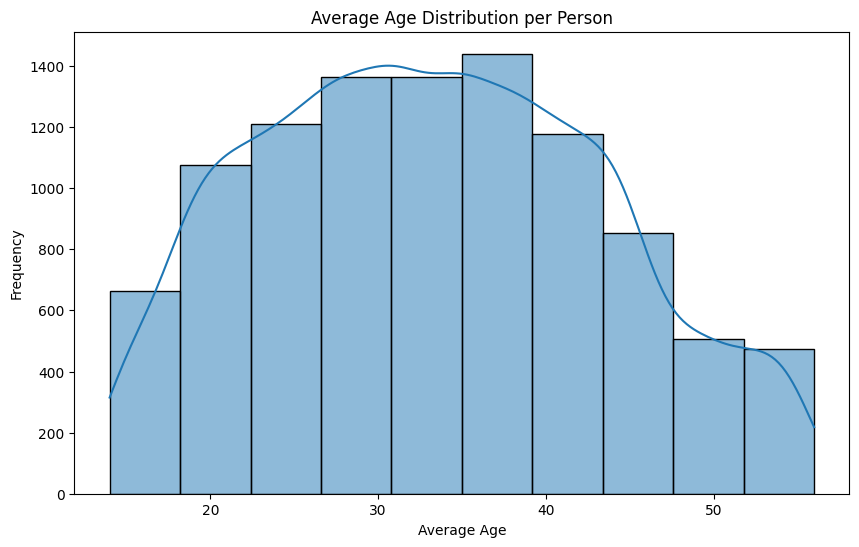

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

avg_age_per_person = df_filtered.groupby('Name')['Age'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_age_per_person, kde=True, bins=10)
plt.title('Average Age Distribution per Person')
plt.xlabel('Average Age')
plt.ylabel('Frequency')
plt.show()


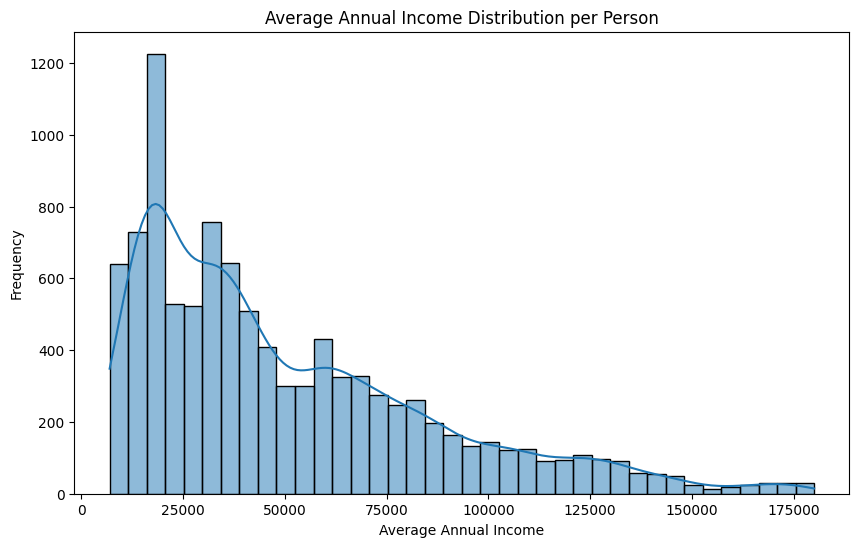

In [195]:
avg_aincome_pperson = df_filtered.groupby('Name')['Annual_Income'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_aincome_pperson, kde=True)
plt.title('Average Annual Income Distribution per Person')
plt.xlabel('Average Annual Income')
plt.ylabel('Frequency')
plt.show()


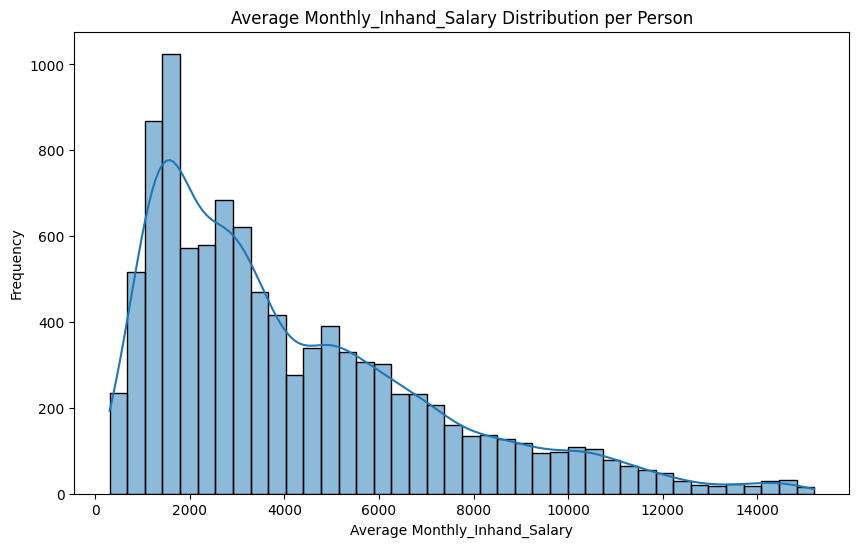

In [196]:
avg_monthly_inhand_salary_pperson = df_filtered.groupby('Name')['Monthly_Inhand_Salary'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_monthly_inhand_salary_pperson, kde=True)
plt.title('Average Monthly_Inhand_Salary Distribution per Person')
plt.xlabel('Average Monthly_Inhand_Salary')
plt.ylabel('Frequency')
plt.show()


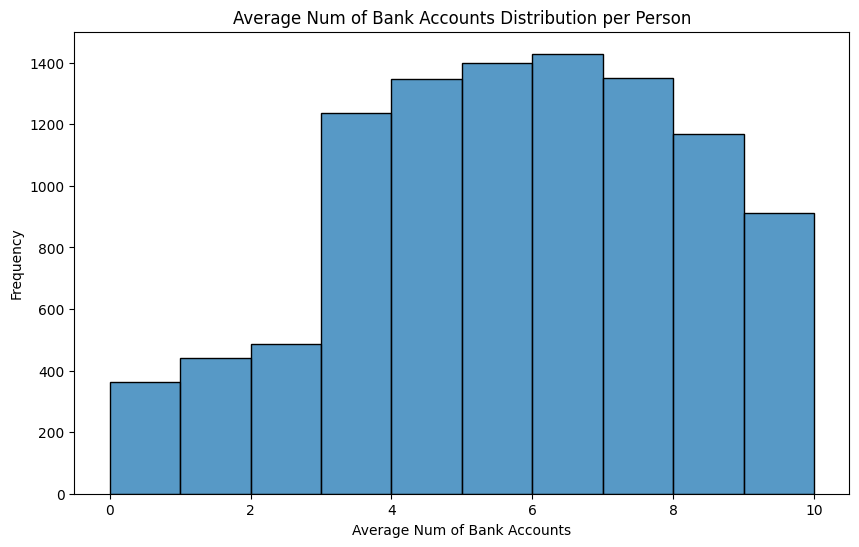

In [197]:
avg_num_bank_account_pperson = df_filtered.groupby('Name')['Num_Bank_Accounts'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_num_bank_account_pperson, bins=10)
plt.title('Average Num of Bank Accounts Distribution per Person')
plt.xlabel('Average Num of Bank Accounts')
plt.ylabel('Frequency')
plt.show()

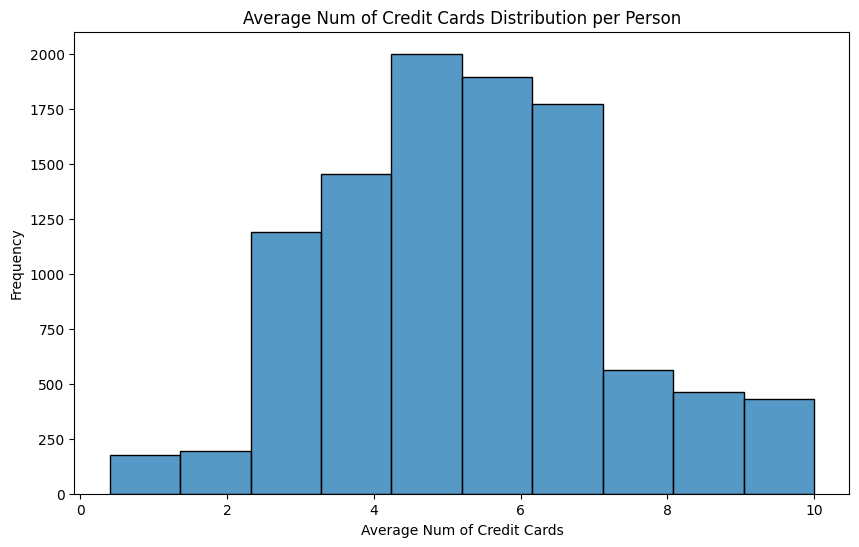

In [198]:
avg_num_credit_card_pperson = df_filtered.groupby('Name')['Num_Credit_Card'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_num_credit_card_pperson, bins=10)
plt.title('Average Num of Credit Cards Distribution per Person')
plt.xlabel('Average Num of Credit Cards')
plt.ylabel('Frequency')
plt.show()

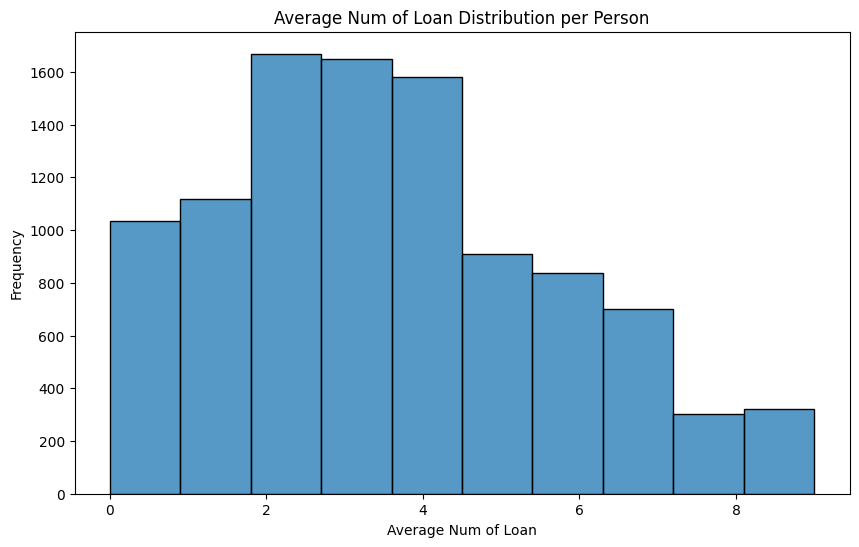

In [199]:
avg_num_loan_pperson = df_filtered.groupby('Name')['Num_of_Loan'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_num_loan_pperson, bins=10)
plt.title('Average Num of Loan Distribution per Person')
plt.xlabel('Average Num of Loan')
plt.ylabel('Frequency')
plt.show()

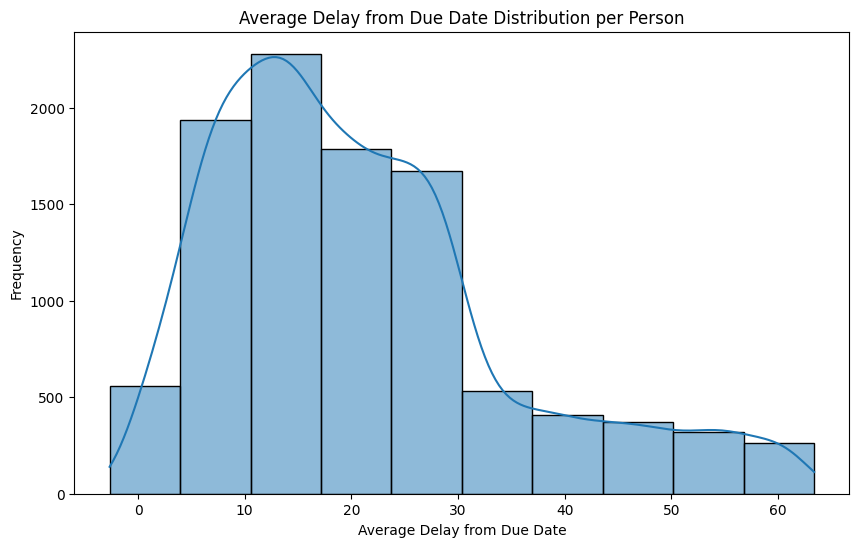

In [200]:
avg_delay_from_due_date_pperson = df_filtered.groupby('Name')['Delay_from_due_date'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_delay_from_due_date_pperson, bins=10, kde=True)
plt.title('Average Delay from Due Date Distribution per Person')
plt.xlabel('Average Delay from Due Date')
plt.ylabel('Frequency')
plt.show()

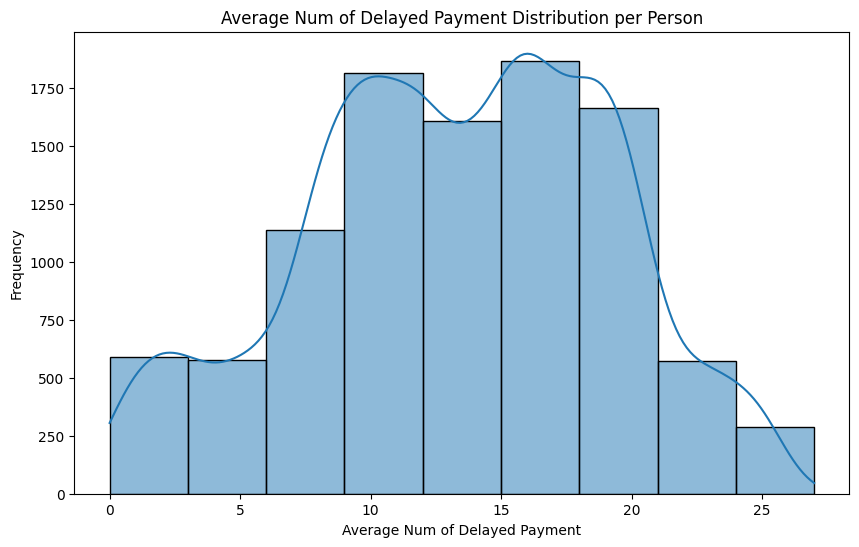

In [201]:
avg_num_delayed_payment_pperson = df_filtered.groupby('Name')['Num_of_Delayed_Payment'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_num_delayed_payment_pperson, bins=9, kde=True)
plt.title('Average Num of Delayed Payment Distribution per Person')
plt.xlabel('Average Num of Delayed Payment')
plt.ylabel('Frequency')
plt.show()

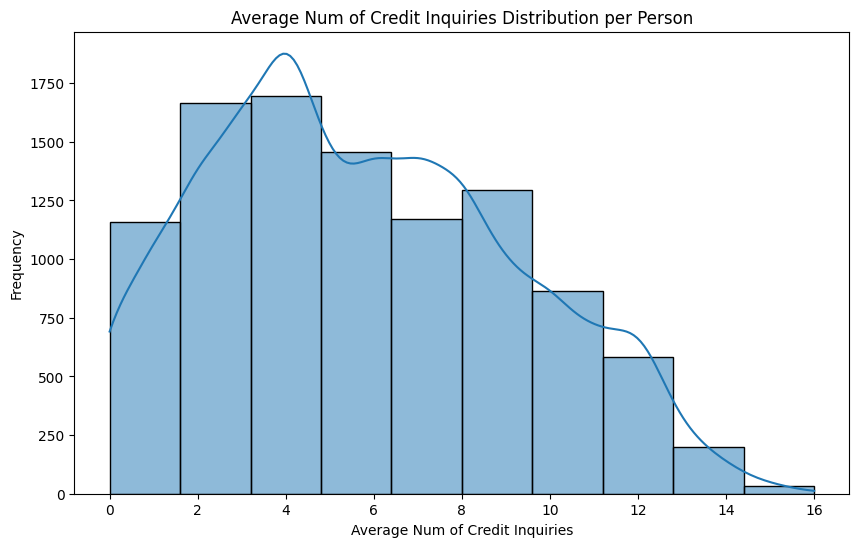

In [202]:
avg_num_credit_inquiries_pperson = df_filtered.groupby('Name')['Num_Credit_Inquiries'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_num_credit_inquiries_pperson, bins=10, kde=True)
plt.title('Average Num of Credit Inquiries Distribution per Person')
plt.xlabel('Average Num of Credit Inquiries')
plt.ylabel('Frequency')
plt.show()

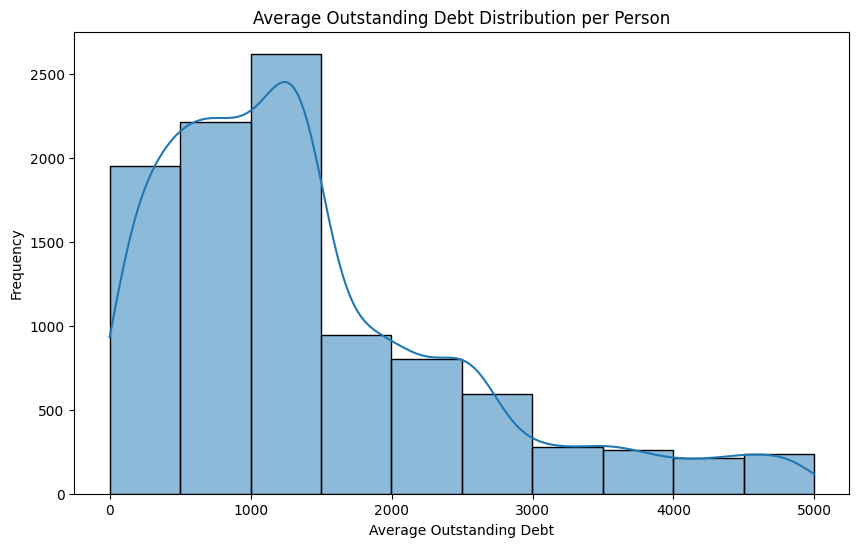

In [203]:
avg_outstanding_debt_pperson = df_filtered.groupby('Name')['Outstanding_Debt'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_outstanding_debt_pperson, bins=10, kde=True)
plt.title('Average Outstanding Debt Distribution per Person')
plt.xlabel('Average Outstanding Debt')
plt.ylabel('Frequency')
plt.show()

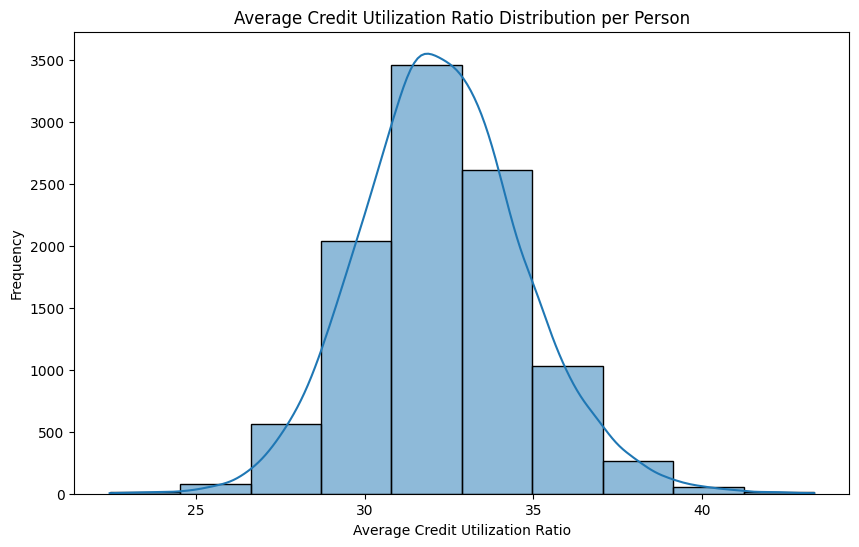

In [204]:
avg_credit_util_ratio_pperson = df_filtered.groupby('Name')['Credit_Utilization_Ratio'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_credit_util_ratio_pperson, bins=10, kde=True)
plt.title('Average Credit Utilization Ratio Distribution per Person')
plt.xlabel('Average Credit Utilization Ratio')
plt.ylabel('Frequency')
plt.show()

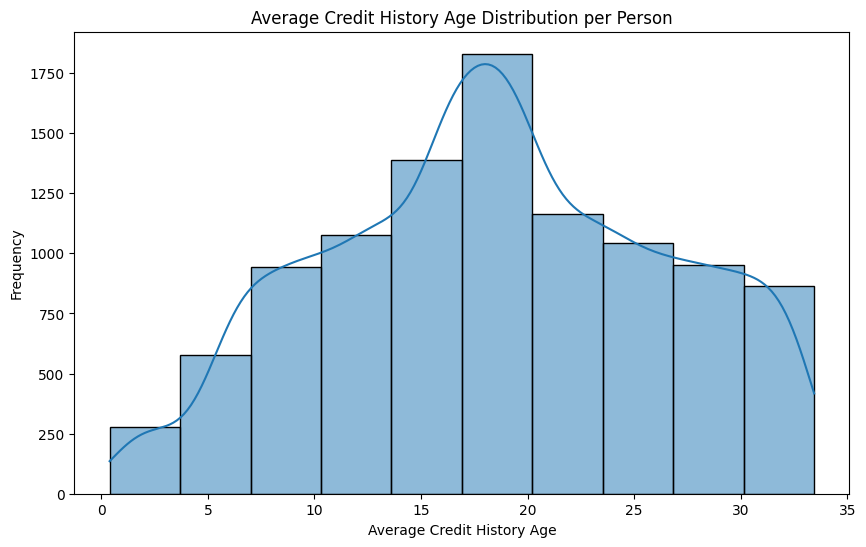

In [205]:
avg_credit_history_age_pperson = df_filtered.groupby('Name')['Credit_History_Age_in_Years'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_credit_history_age_pperson, bins=10, kde=True)
plt.title('Average Credit History Age Distribution per Person')
plt.xlabel('Average Credit History Age')
plt.ylabel('Frequency')
plt.show()

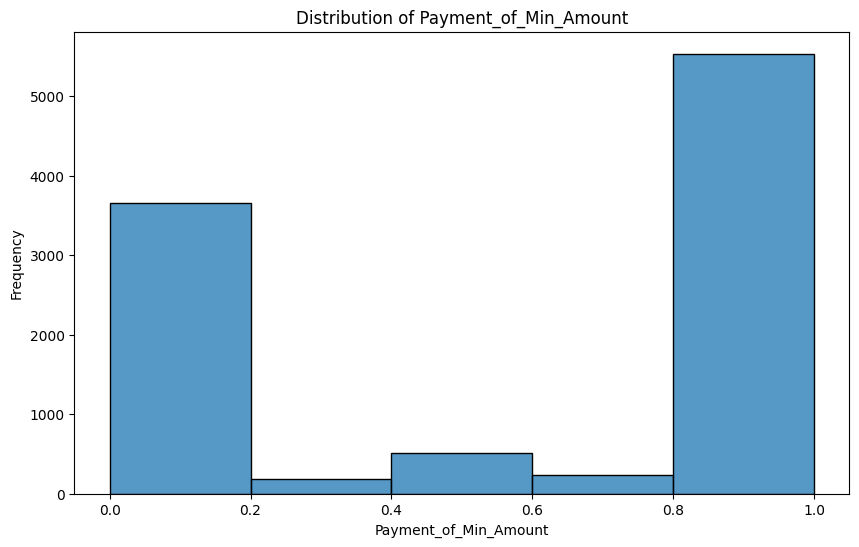

In [206]:
avg_credit_history_age_pperson = df_filtered.groupby('Name')['Payment_of_Min_Amount'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_credit_history_age_pperson, bins=5)
plt.title('Distribution of Payment_of_Min_Amount')
plt.xlabel('Payment_of_Min_Amount')
plt.ylabel('Frequency')
plt.show()

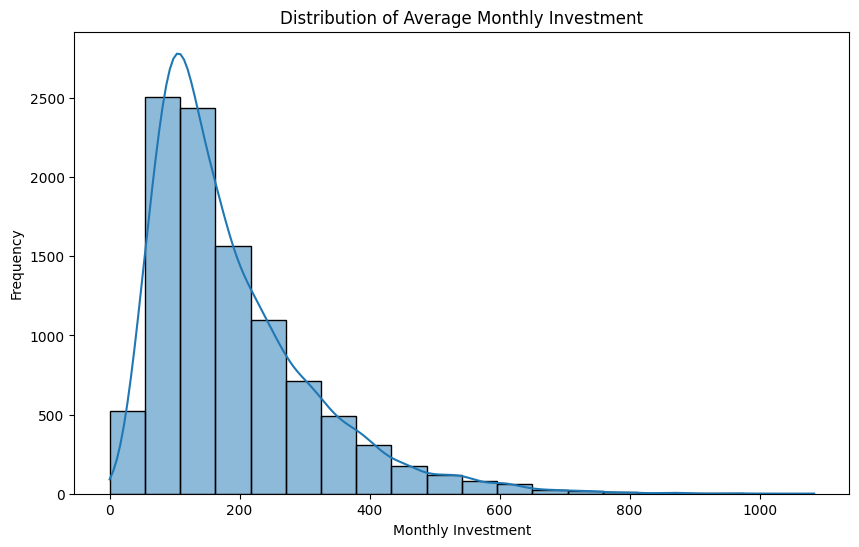

In [207]:
avg_monthly_investment_pperson = df_filtered.groupby('Name')['Amount_invested_monthly'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_monthly_investment_pperson, bins=20, kde=True)
plt.title('Distribution of Average Monthly Investment')
plt.xlabel('Monthly Investment')
plt.ylabel('Frequency')
plt.show()

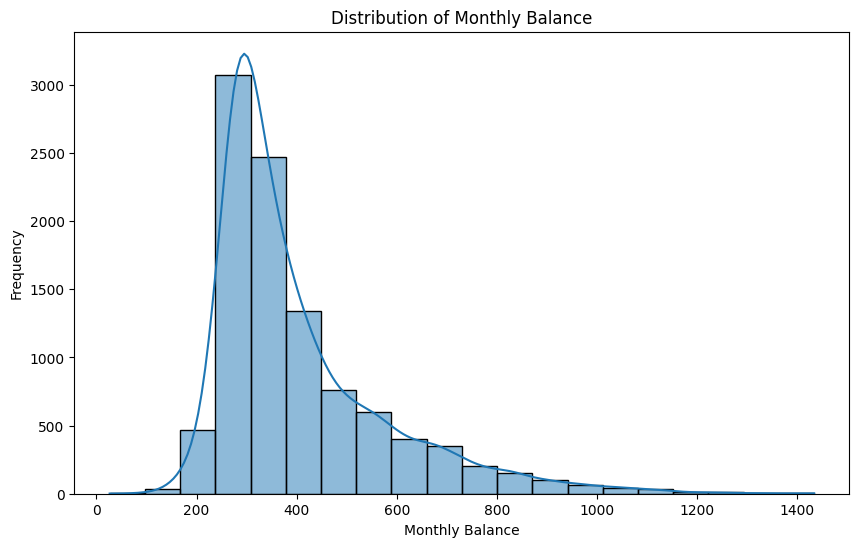

In [208]:
avg_monthly_balance_pperson = df_filtered.groupby('Name')['Monthly_Balance'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_monthly_balance_pperson, bins=20, kde=True)
plt.title('Distribution of Monthly Balance')
plt.xlabel('Monthly Balance')
plt.ylabel('Frequency')
plt.show()

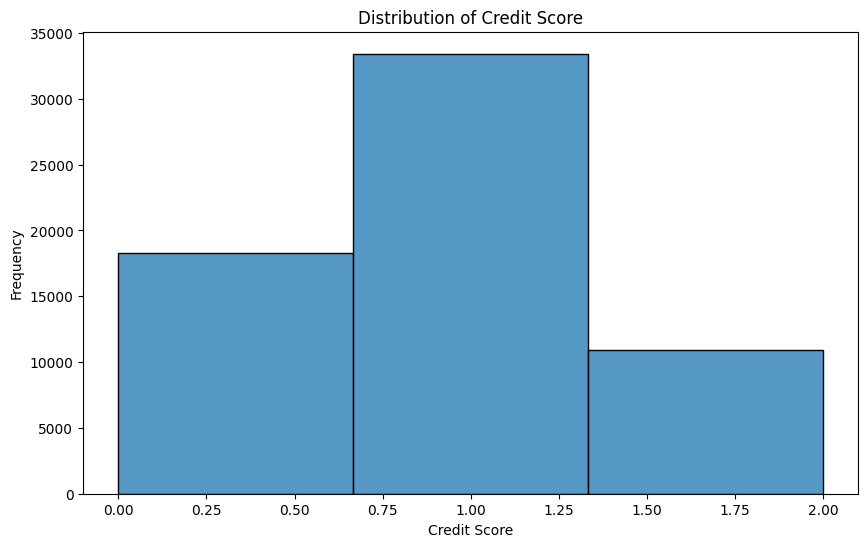

In [209]:
credit_score_pperson = df_filtered['Credit_Score']

plt.figure(figsize=(10, 6))
sns.histplot(credit_score_pperson, bins=3)
plt.title('Distribution of Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

### Bivariate Distribution Plot

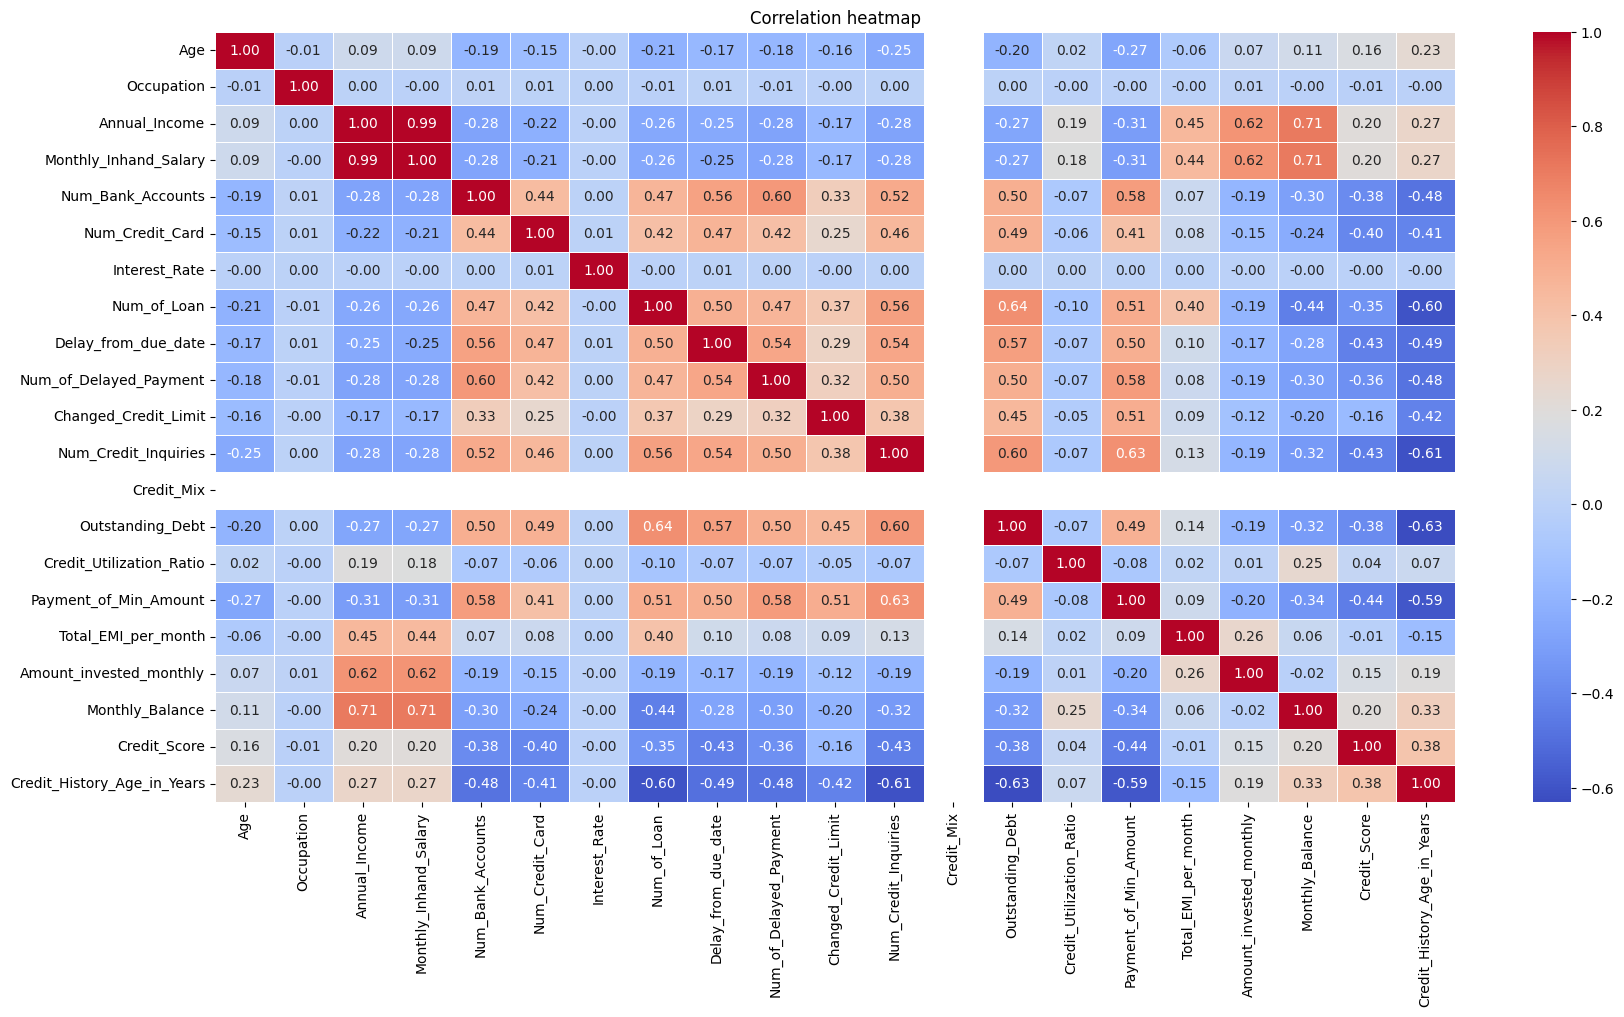

In [210]:
df_numeric = df_filtered.select_dtypes(include=['float64', 'int64'])
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation heatmap")
plt.show()

<Figure size 1200x600 with 0 Axes>

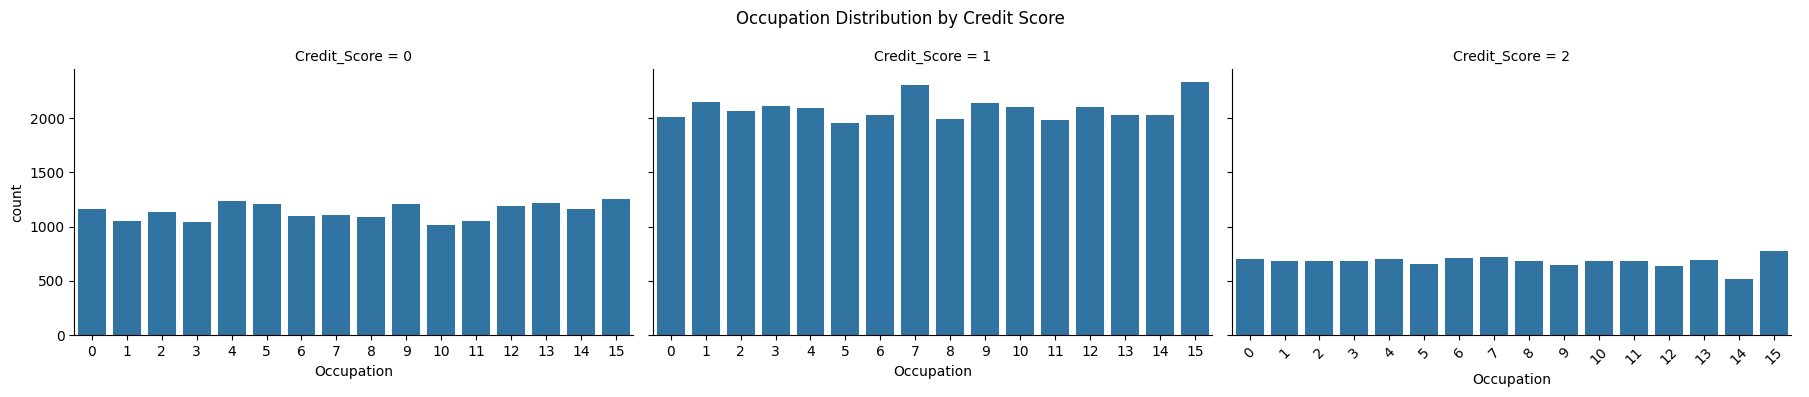

In [211]:
plt.figure(figsize=(12, 6))
sns.catplot(data=df_filtered, x="Occupation", col="Credit_Score", kind="count", height=4, aspect=1.5)
plt.suptitle('Occupation Distribution by Credit Score')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

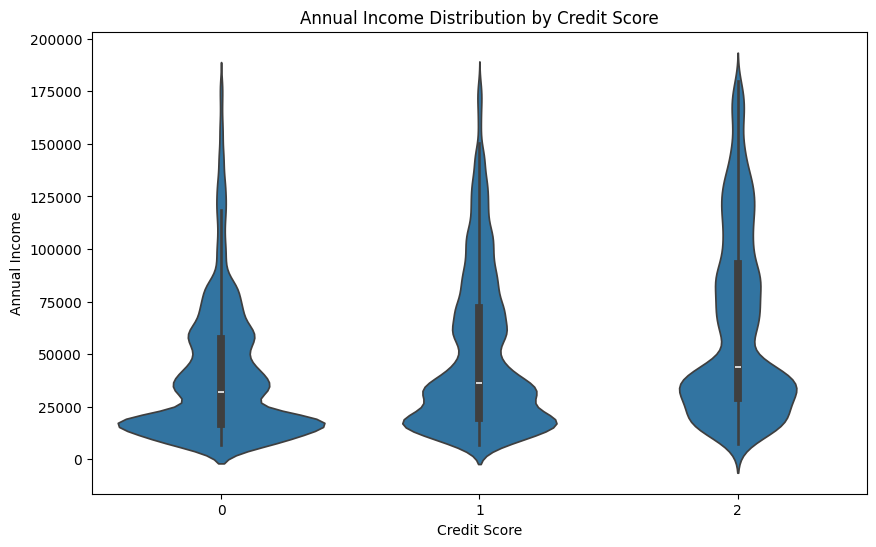

In [212]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=credit_score_pperson, y=df_filtered["Annual_Income"])
plt.title('Annual Income Distribution by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Annual Income')
plt.show()

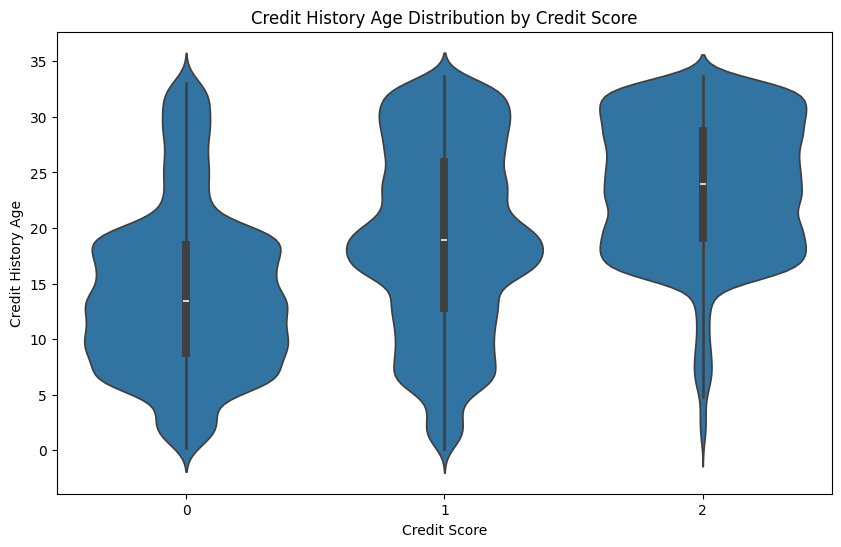

In [213]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=credit_score_pperson, y=df_filtered["Credit_History_Age_in_Years"])
plt.title('Credit History Age Distribution by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Credit History Age')
plt.show()

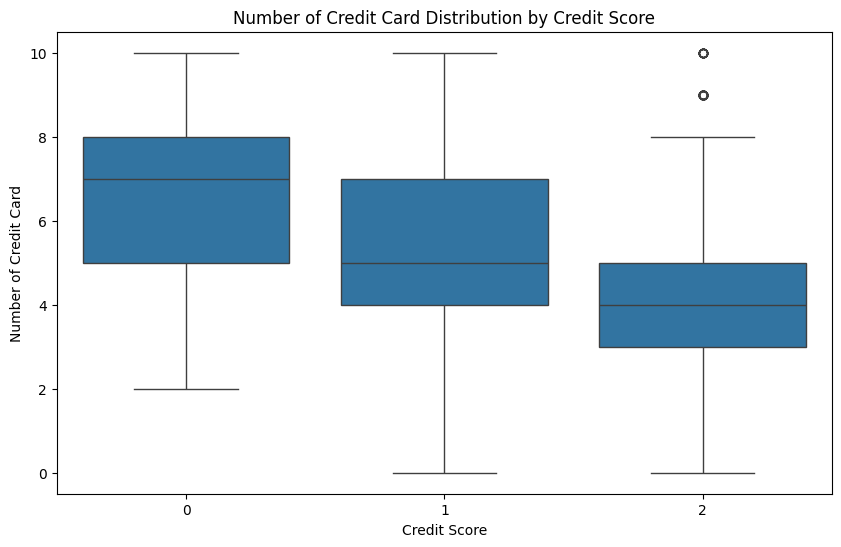

In [214]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=credit_score_pperson, y=df_filtered["Num_Credit_Card"])
plt.title('Number of Credit Card Distribution by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Number of Credit Card')
plt.show()

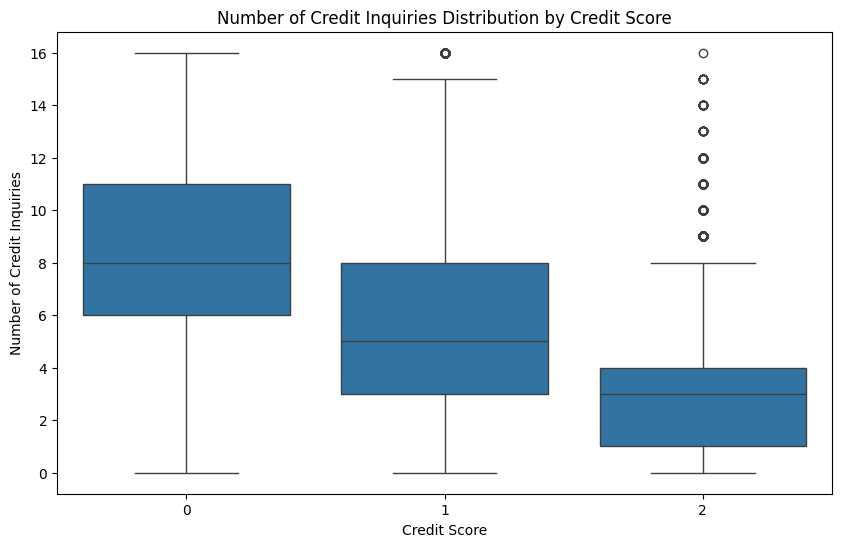

In [215]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=credit_score_pperson, y=df_filtered["Num_Credit_Inquiries"])
plt.title('Number of Credit Inquiries Distribution by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Number of Credit Inquiries')
plt.show()

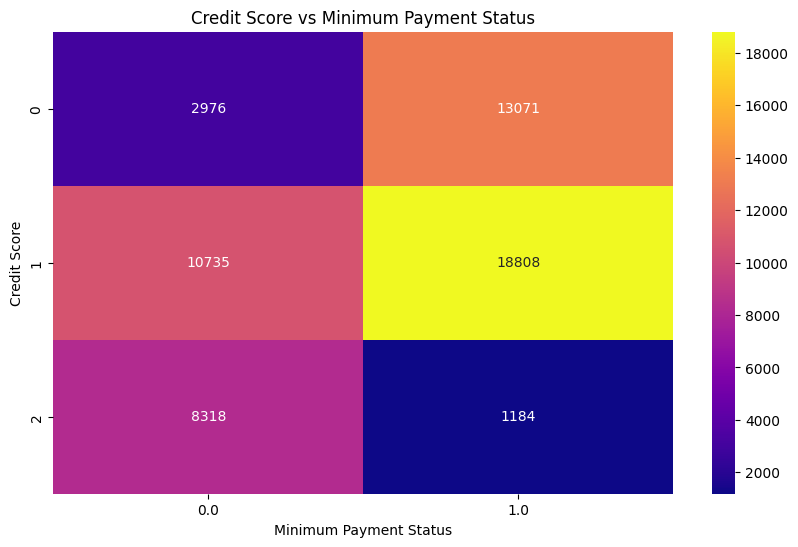

In [216]:
plt.figure(figsize=(10, 6))
cross_tab = pd.crosstab(credit_score_pperson, df_filtered["Payment_of_Min_Amount"])

sns.heatmap(cross_tab, annot=True, fmt="d", cmap="plasma")
plt.title("Credit Score vs Minimum Payment Status")
plt.xlabel("Minimum Payment Status")
plt.ylabel("Credit Score")
plt.show()

## Model Training

In [217]:
back_df = df_filtered.copy()
back_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Years
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,26.822620,22 Years and 1 Months,0.0,49.574949,80.415295,High_spent_Small_value_payments,312.494089,2,22.083333
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,28.609352,22 Years and 3 Months,0.0,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,2,22.250000
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,31.377862,22 Years and 4 Months,0.0,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,2,22.333333
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,27.262259,22 Years and 6 Months,0.0,49.574949,62.430172,!@9#%8,340.479212,2,22.500000
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23.0,821-00-0265,12,19114.12,1824.843333,3,...,809.98,22.537593,22 Years and 7 Months,0.0,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,2,22.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0x25fe8,CUS_0x942c,March,Nicks,25.0,078-73-5990,9,39628.99,3359.415833,4,...,502.38,39.323569,31 Years and 5 Months,0.0,35.104023,140.581403,High_spent_Medium_value_payments,410.256158,0,31.416667
99995,0x25fe9,CUS_0x942c,April,Nicks,25.0,078-73-5990,9,39628.99,3359.415833,4,...,502.38,34.663572,31 Years and 6 Months,0.0,35.104023,60.971333,High_spent_Large_value_payments,479.866228,0,31.500000
99996,0x25fea,CUS_0x942c,May,Nicks,25.0,078-73-5990,9,39628.99,3359.415833,4,...,502.38,40.565631,31 Years and 7 Months,0.0,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,0,31.583333
99997,0x25feb,CUS_0x942c,June,Nicks,25.0,078-73-5990,9,39628.99,3359.415833,4,...,502.38,41.255522,31 Years and 8 Months,0.0,35.104023,24.028477,High_spent_Large_value_payments,516.809083,0,31.666667


In [218]:
df_filtered = back_df.copy()
dict = {
    'High_spent_Small_value_payments' : 0,
    'Low_spent_Large_value_payments' : 1,
    'Low_spent_Medium_value_payments' : 2,
    'Low_spent_Small_value_payments' : 3,
    'High_spent_Medium_value_payments' : 4,
    'High_spent_Large_value_payments': 5,
    '!@9#%8' : np.nan
}

df_filtered['Payment_Behaviour'] = df_filtered['Payment_Behaviour'].map(dict)
label_encoder = LabelEncoder()

df_filtered.drop("ID", axis=1, inplace=True)
df_filtered.drop("Name", axis=1, inplace=True)
df_filtered.drop("Customer_ID", axis=1, inplace=True)
df_filtered.drop("SSN", axis=1, inplace=True)
df_filtered.drop("Type_of_Loan", axis=1, inplace=True)
df_filtered.drop("Monthly_Inhand_Salary", axis=1, inplace=True)
df_filtered.drop("Credit_History_Age", axis=1, inplace=True)
df_filtered.drop("Month", axis=1, inplace=True)
df_filtered.drop(['Monthly_Balance', 'Credit_Utilization_Ratio', "Interest_Rate", "Occupation", "Age"], axis=1, inplace=True)
print(df_filtered.isna().sum())


Annual_Income                     0
Num_Bank_Accounts                 0
Num_Credit_Card                   0
Num_of_Loan                       0
Delay_from_due_date               0
Num_of_Delayed_Payment            0
Changed_Credit_Limit           1340
Num_Credit_Inquiries              0
Credit_Mix                        0
Outstanding_Debt                  0
Payment_of_Min_Amount          7475
Total_EMI_per_month               0
Amount_invested_monthly           0
Payment_Behaviour              4728
Credit_Score                      0
Credit_History_Age_in_Years    5679
dtype: int64


In [219]:
from imblearn.over_sampling import SMOTE

df_filtered = df_filtered.dropna()

X = df_filtered.drop(['Credit_Score'], axis=1)
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
y = df_filtered['Credit_Score']
X = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
sm = SMOTE(k_neighbors=7)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

## Load trained model (Without PyCaret but Scikit-learn==1.4.2 and catboost are needed)

In [220]:
import joblib

best_model = joblib.load("./drive/MyDrive/Colab Notebooks/ExtraTreeClf_sklearn_latest.pkl")
best_model

ExtraTreesClassifier(n_jobs=-1, random_state=7570)

In [221]:
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier

isinstance(best_model, ExtraTreesClassifier)

True

In [222]:
ensemble_model = joblib.load("EnsembleClf_sklearn_latest.pkl")
ensemble_model

StackingClassifier(cv=5,
                   estimators=[('Random Forest Classifier',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=7570)),
                               ('CatBoost Classifier',
                                <catboost.core.CatBoostClassifier object at 0x7fe6ce3e6560>),
                               ('Extra Trees Classifier',
                                ExtraTreesClassifier(n_jobs=-1,
                                                     random_state=7570))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=7570),
                   n_jobs=1)

In [223]:
isinstance(ensemble_model, StackingClassifier)

True

## Search for Feature Values Using Bayes Optimization with Constraint

In [224]:
X_test_original = X_test.copy()
X_test_original = pd.DataFrame(sc.inverse_transform(X_test_original), columns=X_test_original.columns)
X_train_original = X_train.copy()
X_train_original = pd.DataFrame(sc.inverse_transform(X_train_original), columns=X_train_original.columns)
current_sample = X_test_original.iloc[20]
current_sample

,20
Annual_Income,20415.520000
Num_Bank_Accounts,7.000000
Num_Credit_Card,6.000000
Num_of_Loan,5.000000
Delay_from_due_date,61.000000
Num_of_Delayed_Payment,11.000000
Changed_Credit_Limit,7.420000
Num_Credit_Inquiries,9.000000
Credit_Mix,0.000000
Outstanding_Debt,2590.010000


In [225]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier

class CreditScoreOptimizer:
    def __init__(self, current_sample, X_train, sc, best_model):
        """
            Parameters:
            current_sample: samples that are not normalized
            X_train: training data that are not normalized
            sc: StandardScaler
            best_model: trained model
        """
        self.current_sample = current_sample
        self.X_train = X_train
        self.sc = sc
        self.best_model = best_model
        self.max_values = X_train.max()
        self.min_values = X_train.min()
        self.unchanged_features = ["Age", "Occupation", "Payment_Behaviour", "Credit_History_Age_in_Years", "Interest_Rate"]

        self.constraints = {
            'max_dti_ratio': 0.43,      # Maximum debt-to-income ratio
            'max_utilization': 0.80,    # Maximum credit utilization
            'max_emi_to_income': 0.36   # Maximum EMI to income ratio
        }

        self.categorical_values = {feature: sorted(X_train[feature].unique()) for feature in ['Credit_Mix', 'Payment_Behaviour'] if feature in X_train.columns}

        self.feature_types = {
            'integer_features': ['Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries'],
            'binary_features': ['Payment_of_Min_Amount'],
            'categorical_features': list(self.categorical_values.keys()),
            'continuous_features': ['Annual_Income', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month',
                                  'Amount_invested_monthly', 'Credit_History_Age_in_Years', 'Delay_from_due_date']
        }

        self.feature_relationships = {
            'Total_EMI_per_month': {
                'formula': lambda params: (min((params['Annual_Income']/12) * self.constraints['max_emi_to_income'], params['Total_EMI_per_month'])),
                'weight': 1.0
            },
            'Amount_invested_monthly': {
                'formula': lambda params: (min((params['Annual_Income']/12 - params['Total_EMI_per_month']) * 0.7, params['Amount_invested_monthly'])),
                'weight': 1.0
            }
        }

        # Reasonable feature bounds
        self.feature_bounds = {
            'Num_Bank_Accounts': (1, 6),
            'Num_Credit_Card': (1, 5),
            'Num_of_Loan': (1, 4),
            "Delay_from_due_date": (0, 30),
            "Num_of_Delayed_Payment": (0, 9),
            "Changed_Credit_Limit": (0, 8),
            "Num_Credit_Inquiries": (0, 8),
            "Outstanding_Debt": (0.1 * self.current_sample["Outstanding_Debt"], self.constraints["max_dti_ratio"] * self.current_sample["Outstanding_Debt"]),
            "Annual_Income": (0.95 * self.current_sample["Annual_Income"], 1.05 * self.current_sample["Annual_Income"]),
            'Total_EMI_per_month': (0, self.constraints["max_emi_to_income"] * self.current_sample["Annual_Income"] / 12),
            'Amount_invested_monthly': (0, 0.4 * self.current_sample["Annual_Income"] / 12)
        }

    def get_feature_importance(self):
        """Feature Importance Ranking"""
        if isinstance(self.best_model, ExtraTreesClassifier):
            importance = self.best_model.feature_importances_
        elif isinstance(self.best_model, StackingClassifier):
            importance = self.best_model.estimators_[2].feature_importances_

        feature_importance = pd.DataFrame({'feature': self.X_train.columns, 'importance': importance})

        # Exclude unused features
        feature_importance = feature_importance[~feature_importance['feature'].isin(['Age', 'Occupation'])]

        return feature_importance.sort_values('importance', ascending=False)

    def _normalize_sample(self, sample):
        """Normalize samples"""
        sample_df = pd.DataFrame([sample])
        return pd.DataFrame(self.sc.transform(sample_df), columns=sample_df.columns)

    def _check_constraints(self, params):
        """Calculate penalty for constraint violations"""
        penalty = 0

        # Check feature relationship constraints
        for feature, relationship in self.feature_relationships.items():
            if feature in params:
                expected_value = relationship['formula'](params)
                actual_value = params[feature]
                # print("!", feature, expected_value, actual_value)
                penalty += abs(expected_value - actual_value) * relationship['weight']

        # Check global constraints
        if 'Total_EMI_per_month' in params and 'Monthly_Inhand_Salary' in params:
            if params['Total_EMI_per_month'] / params['Monthly_Inhand_Salary'] > self.constraints['max_emi_to_income']:
                print("Max emi to income constraints exceeded.")
                penalty += 1000
        if 'Credit_Utilization_Ratio' in params and params['Credit_Utilization_Ratio'] > self.constraints['max_utilization']:
            print("Max utilization ration constraints exceeded.")
            penalty += 1000
        if 'Monthly_Balance' in params and params['Monthly_Balance'] < self.constraints['min_monthly_balance']:
            print("Min monthly balance exceeded.")
            penalty += 1000

        return penalty

    def _get_feature_space(self, feature, correlation, epsilon=1e-4):
        """Define search space"""
        current_value = self.current_sample[feature]
        if feature in self.feature_types['categorical_features']:
            return hp.choice(feature, self.categorical_values[feature])
        if feature in self.feature_types['binary_features']:
            return hp.choice(feature, [0, 1])

        # Get boundary
        bounds = self.feature_bounds.get(feature, (None, None))
        min_bound = bounds[0] if bounds[0] is not None else float('-inf')
        max_bound = bounds[1] if bounds[1] is not None else float('inf')

        # Define search bound
        if correlation > 0:
            lower = current_value
            upper = min(max_bound, max(self.max_values[feature], current_value + epsilon))
        else:
            lower = max(min_bound, min(self.min_values[feature], current_value - epsilon))
            upper = current_value
        if feature in self.feature_types['integer_features']:
            return hp.quniform(feature, lower, upper, 1)
        return hp.uniform(feature, lower, upper)

    def progressive_optimize(self, correlation_matrix, max_features=None, base_max_evals=100):
        """
          Progressively adding features into the optimization space

          Parameters:
              max_features : int or None
              base_max_evals : int
        """
        feature_importance = self.get_feature_importance()
        if max_features is not None:
            feature_importance = feature_importance.head(max_features)
        best_score = float('-inf')
        best_params = None
        current_best_sample = self.current_sample.copy()

        for i in range(len(feature_importance)):
            current_features = feature_importance['feature'].iloc[:i+1].tolist()
            print(f"\nOptimizing with features: {current_features}")

            space = {}
            skip_flag = False
            for j, feature in enumerate(current_features):
                if feature not in correlation_matrix["Credit_Score"]:
                    print(f"Feature {feature} not found in correlation_matrix")
                    if j == len(current_features) - 1:
                      skip_flag = True
                    continue
                elif feature in self.unchanged_features:
                    print(f"Feature {feature} will not be included in the search space.")
                    if j == len(current_features) - 1:
                      skip_flag = True
                    continue
                correlation = correlation_matrix["Credit_Score"][feature]
                space[feature] = self._get_feature_space(feature, correlation)
            if skip_flag:
                continue
            current_max_evals = base_max_evals * (i + 1)

            def objective(params):
                modified_sample = current_best_sample.copy()
                for feature, value in params.items():
                    if feature in self.feature_types['categorical_features']:
                        choices = self.categorical_values[feature]
                        modified_sample[feature] = choices[int(value)]
                    else:
                        modified_sample[feature] = value

                # Add constraint penalty
                constraint_penalty = self._check_constraints(modified_sample)

                # Normalize samples
                normalized_sample = self._normalize_sample(modified_sample)
                pred = self.best_model.predict(normalized_sample)[0]

                return 2 - (pred - constraint_penalty * 0.1)

            trials = Trials()
            best = fmin(
                fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=current_max_evals,
                trials=trials
            )

            # Update current sample
            for feature, value in best.items():
                if feature in self.feature_types['categorical_features']:
                    choices = self.categorical_values[feature]
                    current_best_sample[feature] = choices[int(value)]
                elif feature in self.feature_types['integer_features']:
                    current_best_sample[feature] = int(round(value))
                else:
                    current_best_sample[feature] = value

            # Evaluate current result
            normalized_best = self._normalize_sample(current_best_sample)
            current_score = self.best_model.predict(normalized_best)[0]
            print(current_best_sample[current_features])

            print(f"Current score with {i+1} features: {current_score}")

            # Update the global best score
            if current_score > best_score:
                best_score = current_score
                best_params = current_best_sample.copy()
                print("Found new best score!")

            if best_score == 2:
                print("Best parameters found:")
                print(current_best_sample[current_features])
                print("Reached target score, stopping optimization.")
                break

        return best_params, best_score
    def generate_advice(self, optimized_params, original_params):
        """
        Generates advice by comparing optimized parameters with original parameters.

        Parameters:
            optimized_params (dict): Optimized feature values.
            original_params (pd.Series -> dict): Original feature values before optimization.

        Returns:
            dict: A dictionary with features as keys and advice strings as values.
        """
        if isinstance(original_params, pd.Series):
            original_params = original_params.to_dict()  # Convert Series to dict

        advice = {}
        for feature, optimized_value in optimized_params.items():
            original_value = original_params.get(feature, None)
            if original_value is None:
                advice[feature] = f"No data available for comparison for {feature}."
                continue

          # General Features
            if feature in self.feature_bounds:
                min_bound, max_bound = self.feature_bounds[feature]

                if optimized_value != original_value:
                    if feature in self.feature_types["continuous_features"]:
                        advice[feature] = (
                            f"The value for {feature} was adjusted from {original_value:.2f} to {optimized_value:.2f} "
                            f"to optimize your financial health. If possible, be within the range of ({min_bound:.2f}, {max_bound:.2f})."
                        )
                    elif feature in self.feature_types["integer_features"]:
                        advice[feature] = (
                            f"The number of {feature.replace('_', ' ')} has been changed from {int(original_value)} to {int(optimized_value)}. "
                            f"This adjustment aligns better with your financial goals."
                        )
                    elif feature in self.feature_types["binary_features"]:
                        advice[feature] = (
                            f"The binary setting for {feature.replace('_', ' ')} was switched from {int(original_value)} to {int(optimized_value)}. "
                            f"This helps improve your financial standing."
                        )
                    elif feature in self.feature_types["categorical_features"]:
                        advice[feature] = (
                            f"The categorical value for {feature} was changed from {original_value} to {optimized_value}. "
                            f"This adjustment is recommended for better outcomes."
                        )
                else:
                    advice[feature] = (
                        f"The value for {feature} remains unchanged at {optimized_value}. "
                    )

        return advice


current_sample = X_test_original.iloc[20]

optimizer = CreditScoreOptimizer(current_sample=current_sample, X_train=X_train_original, sc=sc, best_model=best_model)

optimized_params, best_score = optimizer.progressive_optimize(correlation_matrix, base_max_evals=10)
print(f"Optimized Parameters: {optimized_params}")

print("Before optimization: ")
print(current_sample)
print("After optimization: ")
print(optimized_params)



Optimizing with features: ['Outstanding_Debt']
100%|██████████| 10/10 [00:00<00:00, 21.81trial/s, best loss: 2.0]
Outstanding_Debt    787.692316
Name: 20, dtype: float64
Current score with 1 features: 0
Found new best score!

Optimizing with features: ['Outstanding_Debt', 'Payment_of_Min_Amount']
100%|██████████| 20/20 [00:00<00:00, 26.31trial/s, best loss: 1.0]
Outstanding_Debt         346.624818
Payment_of_Min_Amount      0.000000
Name: 20, dtype: float64
Current score with 2 features: 1
Found new best score!

Optimizing with features: ['Outstanding_Debt', 'Payment_of_Min_Amount', 'Delay_from_due_date']
100%|██████████| 30/30 [00:01<00:00, 23.62trial/s, best loss: 1.0]
Outstanding_Debt         295.158188
Payment_of_Min_Amount      0.000000
Delay_from_due_date       22.103131
Name: 20, dtype: float64
Current score with 3 features: 1

Optimizing with features: ['Outstanding_Debt', 'Payment_of_Min_Amount', 'Delay_from_due_date', 'Num_Credit_Inquiries']
100%|██████████| 40/40 [00:01<00:

In [226]:
def initialize_advice_dict(features):
    """
    Initializes an advice dictionary with each feature as a key and an empty list.

    Parameters:
      features (list): List of feature names.

    Returns:
      dict: Dictionary with feature keys and empty lists as values.
    """
    return {feature: [] for feature in features}

In [227]:
features = ["Age", "Occupation", "Annual_Income", "Monthly_Inhand_Salary",'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
            'Type_of_Loan',  'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
            'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly',
            'Payment_Behaviour', 'Monthly_Balance']
advice_dict = initialize_advice_dict(features)
original_sample = current_sample.to_dict()
optimized_advice = optimizer.generate_advice(optimized_params, original_sample)

for feature, advice in optimized_advice.items():
    advice_dict[feature].append(advice)
for feature, advice_list in advice_dict.items():
    if advice_list:  # Only print features with advice
        print(f"{feature}:")
        for advice in advice_list:
            print(f"  - {advice}")

Annual_Income:
  - The value for Annual_Income remains unchanged at 20415.519999999997. 
Num_Bank_Accounts:
  - The number of Num Bank Accounts has been changed from 7 to 4. This adjustment aligns better with your financial goals.
Num_Credit_Card:
  - The number of Num Credit Card has been changed from 6 to 4. This adjustment aligns better with your financial goals.
Num_of_Loan:
  - The value for Num_of_Loan remains unchanged at 5.0. 
Delay_from_due_date:
  - The value for Delay_from_due_date was adjusted from 61.00 to 11.51 to optimize your financial health. If possible, be within the range of (0.00, 30.00).
Num_of_Delayed_Payment:
  - The value for Num_of_Delayed_Payment remains unchanged at 11.0. 
Changed_Credit_Limit:
  - The value for Changed_Credit_Limit remains unchanged at 7.42. 
Num_Credit_Inquiries:
  - The number of Num Credit Inquiries has been changed from 9 to 7. This adjustment aligns better with your financial goals.
Outstanding_Debt:
  - The value for Outstanding_Debt 

In [228]:
print(advice_dict)

{'Age': [], 'Occupation': [], 'Annual_Income': ['The value for Annual_Income remains unchanged at 20415.519999999997. '], 'Monthly_Inhand_Salary': [], 'Num_Bank_Accounts': ['The number of Num Bank Accounts has been changed from 7 to 4. This adjustment aligns better with your financial goals.'], 'Num_Credit_Card': ['The number of Num Credit Card has been changed from 6 to 4. This adjustment aligns better with your financial goals.'], 'Interest_Rate': [], 'Num_of_Loan': ['The value for Num_of_Loan remains unchanged at 5.0. '], 'Type_of_Loan': [], 'Delay_from_due_date': ['The value for Delay_from_due_date was adjusted from 61.00 to 11.51 to optimize your financial health. If possible, be within the range of (0.00, 30.00).'], 'Num_of_Delayed_Payment': ['The value for Num_of_Delayed_Payment remains unchanged at 11.0. '], 'Changed_Credit_Limit': ['The value for Changed_Credit_Limit remains unchanged at 7.42. '], 'Num_Credit_Inquiries': ['The number of Num Credit Inquiries has been changed fr

In [229]:
def append_resources(advice_dict):
    """
    Appends resource links to the advice for each feature in the dictionary.

    Parameters:
        advice_dict (dict): The original advice dictionary with feature-specific advice.

    Returns:
        dict: The updated advice dictionary with resource links appended.
    """
    advice_resources = {'Age': ["https://www.nerdwallet.com/article/finance/what-is-the-average-credit-score-by-age-and-what-is-a-good-score-for-my-age"],
                    'Occupation': ["https://www.experian.com/blogs/ask-experian/credit-education/life-events/employment/"],
                'Annual_Income': ["https://www.cnbc.com/select/how-does-salary-and-income-impact-your-credit-score/"],
                'Monthly_Inhand_Salary': ["https://www.cnbc.com/select/how-does-salary-and-income-impact-your-credit-score/"],
                'Num_Bank_Accounts': ["https://www.mybanktracker.com/credit-cards/credit-score/bank-accounts-hurt-credit-score-20174#:~:text=Quick%20answer%3A%20Credit%20scores%20are%20not%20affected%20by,are%20based%20on%20data%20on%20your%20credit%20report."],
                'Num_Credit_Card': ["https://www.investopedia.com/ask/answers/07/credit_score.asp"],
                'Interest_Rate': ["https://www.experian.com/blogs/ask-experian/do-lower-interest-rates-affect-your-credit-score/"],
                'Num_of_Loan': ["https://www.americanexpress.com/en-us/credit-cards/credit-intel/does-applying-for-multiple-loans-affect-your-credit-score/"],
                'Type_of_Loan': ["https://www.experian.com/blogs/ask-experian/credit-education/improving-credit/improve-credit-score/?msockid=1e7a629a1c436b37287c6db51dc76aa2"],
                'Delay_from_due_date': ["https://www.nerdwallet.com/article/finance/late-bill-payment-reported"],
                'Num_of_Delayed_Payment':["https://www.credit.com/blog/5-myths-about-late-payments-your-fico-scores-71720/"],
                'Changed_Credit_Limit': ["https://www.cnbc.com/select/does-requesting-a-credit-limit-increase-affect-your-credit-score/?msockid=1e7a629a1c436b37287c6db51dc76aa2"],
                'Num_Credit_Inquiries': ["https://www.experian.com/blogs/ask-experian/do-multiple-loan-inquiries-affect-your-credit-score/?msockid=1e7a629a1c436b37287c6db51dc76aa2"],
                'Credit_Mix': ["https://www.experian.com/blogs/ask-experian/credit-education/improving-credit/improve-credit-score/?msockid=1e7a629a1c436b37287c6db51dc76aa2"],
                'Outstanding_Debt': ["https://www.thebalancemoney.com/how-your-debt-affects-your-credit-score-960489","https://www.forbes.com/advisor/credit-cards/debt-snowball-vs-debt-avalanche-the-best-way-to-pay-off-credit-card-debt/"],
                'Credit_Utilization_Ratio': ["https://www.businessinsider.com/personal-finance/credit-score/credit-utilization-ratio#:~:text=1%20Your%20credit%20utilization%20ratio%20is%20the%20percentage,utilization%20ratio%20is%20best%20for%20your%20credit%20scores."],
                'Credit_History_Age': ["https://www.experian.com/blogs/ask-experian/credit-education/improving-credit/improve-credit-score/?msockid=1e7a629a1c436b37287c6db51dc76aa2"],
                'Payment_of_Min_Amount': ["https://www.thebalancemoney.com/the-impact-of-minimum-payments-on-your-credit-score-960463"],
                'Total_EMI_per_month': ["https://www.getonecard.app/blog/when-to-use-credit-card-emi-and-when-to-avoid/"],
                'Amount_invested_monthly': ["https://www.chase.com/personal/credit-cards/education/credit-score/do-investments-affect-your-credit-score"],
                'Payment_Behaviour': ["https://www.capitalone.com/learn-grow/money-management/payment-history/"],
                'Monthly_Balance': ["https://www.experian.com/blogs/ask-experian/better-pay-off-credit-card-full-every-month-or-maintain-balance/?msockid=1e7a629a1c436b37287c6db51dc76aa2"]}
    for feature, advice in advice_dict.items():
        resource_links = advice_resources.get(feature, ["No specific resources available."])
        resource_text = "\n".join(resource_links)

        if not advice or advice == []:
            # If advice is empty, only add the resource links
            advice_dict[feature] = f"Here are some resources on how {feature} might affect your credit score:\n{resource_text} \n"
        else:
            # Append resource links to the existing advice for this feature
            advice_dict[feature] = f"{advice[0]}\nHere are some resources on how {feature} might affect your credit score and ways to adjust them:\n{resource_text}\n"


    return advice_dict

In [230]:
#Final Advice Dictionary Output
advice_dict = append_resources(advice_dict)
for feature, advice in advice_dict.items():
    print(f"{feature}: {advice}")

Age: Here are some resources on how Age might affect your credit score:
https://www.nerdwallet.com/article/finance/what-is-the-average-credit-score-by-age-and-what-is-a-good-score-for-my-age 

Occupation: Here are some resources on how Occupation might affect your credit score:
https://www.experian.com/blogs/ask-experian/credit-education/life-events/employment/ 

Annual_Income: The value for Annual_Income remains unchanged at 20415.519999999997. 
Here are some resources on how Annual_Income might affect your credit score and ways to adjust them:
https://www.cnbc.com/select/how-does-salary-and-income-impact-your-credit-score/

Monthly_Inhand_Salary: Here are some resources on how Monthly_Inhand_Salary might affect your credit score:
https://www.cnbc.com/select/how-does-salary-and-income-impact-your-credit-score/ 

Num_Bank_Accounts: The number of Num Bank Accounts has been changed from 7 to 4. This adjustment aligns better with your financial goals.
Here are some resources on how Num_Ba